<h1 style="text-align: center;"><img class="responsive" style="float: left;" src="https://is1-ssl.mzstatic.com/image/thumb/Purple112/v4/b5/6e/20/b56e2053-ccd2-d63f-e0fb-a1bf3774eb0b/AppIcon-0-0-1x_U007emarketing-0-0-0-10-0-0-sRGB-0-0-0-GLES2_U002c0-512MB-85-220-0-0.png/230x0w.webp" alt="" width="143" height="143" /></h1>
<h1 style="text-align: center;"><img class="responsive" style="font-size: 14px; float: right;" src="https://i0.wp.com/mosefparis1.fr/wp-content/uploads/2022/10/cropped-image-1.png?fit=532%2C540&amp;ssl=1" alt="" width="163" height="165" /></h1>
<h1 style="text-align: center;"><span style="color: #000080; font-family: arial, helvetica, sans-serif;"><strong style="font-size: 24pt;">LCL Challenge: Analyse exploratoire et sélection de variables</strong></span></h1>
<p style="text-align: center;"><span style="font-size: 14pt;">Scoring Immobilier: Syst&egrave;me Expert BEST&nbsp;IMMO</span></p>
<p style="text-align: center;"><span style="font-size: 10pt; font-family: verdana, geneva, sans-serif;">Lucie Gabagnou,&nbsp;Ghiles Idris,&nbsp;Armand L'Huillier,&nbsp;Yanis Rehoune</span></p>

Ce projet se fait dans le cadre d'un challenge proposé par Mohamed Sneiba Hamoud. Le but est de challenger le modèle de scoring existant dans l'octroi de crédit immobilier.
Les milestones de sont projets sont les suivantes: 
- Vision globale de la base de données: étude de la période + constitution des échantillons
- Preprocessing sur l'ensemble des variables (valeurs manquantes, traitement de types, etc..)
- Sélection de variables (Lasso et tests univariés avec target) + réflexion nouvelles variables
- Discrétisation des variables quantitatives + regroupement de modalités des variables qualitatives (inclut data viz stabilité)
- Modélisation classique: régression logistique + performances
- Modélisation alternative: modèle challengeant
- Grille de score



# Exploration des données et processing

### Installation de l'environnement de travail

#### Packages

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection  import train_test_split
import warnings 
warnings.filterwarnings("ignore")



In [2]:
from scripts.processing import convert_modalities_to_quali,na_sup_20_fill_by_0_vs_autres,compare_na_variables_duplicates,fill_by_0,imputation_for_na,get_dummies_var,drop_columns,proxys_processing,cross_variable_for_project_type
from scripts.feature_selection import test_kruskall_wallis, test_biserial, test_chi2_independance, cramers_v_btw_X, cramers_v_with_target, selection_avec_lasso,get_feature_selection_rf
from scripts.discretisation import check_mean_defaut_rate_per_category, discretisation_variables_from_chi2
from scripts.group_cat_variables import replace_encoding_by_real_labels,encoding_categorical_variables,selection_categorical_var_post_grouping,group_modalities_with_optbinning
from scripts.pipeline_preprocessing import pipeline_processing
from scripts.firststep_dataviz import min_max_for_datetime_col,missing_rate_report,stabilite_global_temps,dataviz_stability,map_for_default_risk


#### Importation des données

In [3]:
""" Importation de la base de données """
raw_data = pd.read_excel("data/Bases_recents.xlsx")

In [4]:
""" Importation des bases de données externes """
df_geo = pd.read_csv("data/external/geocoordonneesBases_recents.csv")#import du dataframe avec les défauts, les longitudes et les latitudes
chomage_data=pd.read_excel("data/external/taux_chomage.xlsx")
richesse_data=pd.read_excel("data/external/richesse.xlsx")
inondation_data=pd.read_excel("data/external/Gaspar.xlsx")


dict_data_extern={ 
'chomage': chomage_data, 
'richesse': richesse_data,
'inondation': inondation_data,
}

# Etude générale
- Observations de la base, partiulièrement la période étudiée
- Choix de la date de découpage Temps/ Hors-temps
- Constitution des échantillons 
- Map


In [5]:
display(raw_data.head(10))

region_cri  date_debloc_avec_crd DAT_VALIDE_ACCORD_CRI  nb_pret  \
0  ILE DE FRANCE                201405            2010-12-01        1   
1  ILE DE FRANCE                201405            2011-03-14        2   
2           PACA                201407            2011-06-21        1   
3       AUVERGNE                201404            2011-06-27        1   
4  ILE DE FRANCE                201404            2011-09-29        3   
5  ILE DE FRANCE                201407            2011-10-26        1   
6       AUVERGNE                201405            2011-12-23        2   
7  ILE DE FRANCE                201404            2012-05-02        2   
8  ILE DE FRANCE                201502            2012-03-20        1   
9  ILE DE FRANCE                201405            2012-05-03        1   

   TOP_CONNU_BRP  TOP_SCI_BRP  ASU_BIEN_FIN_BRP  NAT_BIEN_FIN_BRP  \
0              0            0                40                10   
1              0            0                10                10   
2              0            0                40                20   
3              0            0                20                20   
4              0            0                10                10   
5              0            0                40                10   
6              0            0                10                10   
7              0            0                10                10   
8              0            0                10                10   
9              0            0                10                20   

   NBR_INT_BRP  NBR_TOT_COEMPR_CRI  ... Mt_credit_nb_ans_rev_prof  \
0            2                   1  ...                  3.140729   
1            2                   1  ...                  0.999205   
2            1                   0  ...                  4.375182   
3            2                   1  ...                  2.006637   
4            1                   0  ...                  4.536824   
5            2                   1  ...                  0.797385   
6            1                   0  ...                  3.335326   
7            1                   0  ...                  5.704616   
8            2                   0  ...                  0.973411   
9            2                   1  ...                  3.599439   

   Epargne_nb_ans_rev_prof rentabilite_loc  financement_tot   quotite  \
0                      NaN             NaN         301510.0  1.083166   
1                      NaN             NaN         190962.0  0.310507   
2                      NaN             NaN         105000.0  1.000000   
3                 0.389825             NaN         215280.0  0.800000   
4                 0.287687             NaN         177700.0  0.585158   
5                      NaN        0.029388          50000.0  0.204082   
6                 0.434783             NaN          92055.0  0.339686   
7                 0.350730             NaN         162650.0  0.856053   
8                      NaN             NaN          38000.0  0.050599   
9                 0.459992             NaN         156500.0  0.392231   

   top_locatif  top_pret_int_ext  top_autre_pret_int  top_autre_pret_ext  \
0            1                 0                   0                   0   
1            0                 0                   0                   0   
2            1                 0                   0                   0   
3            0                 0                   0                   0   
4            0                 1                   1                   1   
5            1                 0                   0                   0   
6            0                 0                   0                   0   
7            0                 0                   0                   0   
8            0                 0                   0                   0   
9            0                 0                   0                   0   

   top_pers_seule  
0               1  
1

#### Définition de la période d'étude
Rq: la date à considérer au cours de l'étude est la date de déblocage et non la date de validation

In [6]:
""" Colonnes de date """
date_columns=["DAT_VALIDE_ACCORD_CRI","date_debloc_avec_crd"]
raw_data["date_debloc_avec_crd"]=pd.to_datetime(raw_data["date_debloc_avec_crd"],format="%Y%m")


""" Etendu de la période pour chacune des dates """

for col in date_columns:
    min_max_for_datetime_col(raw_data,col)

Date minimale pour DAT_VALIDE_ACCORD_CRI: 2014-04-01 00:00:00
Date maximale pour DAT_VALIDE_ACCORD_CRI: 2018-04-01 00:00:00
Date minimale pour date_debloc_avec_crd: 2014-04-01 00:00:00
Date maximale pour date_debloc_avec_crd: 2018-04-01 00:00:00


#### Stabilité dans le temps?

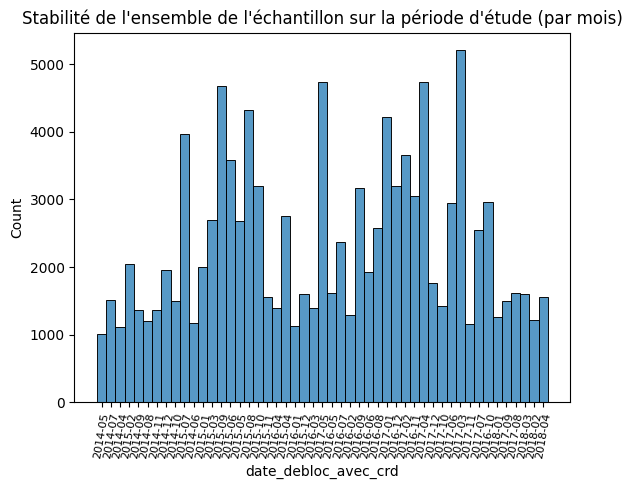

<Figure size 1400x1400 with 0 Axes>

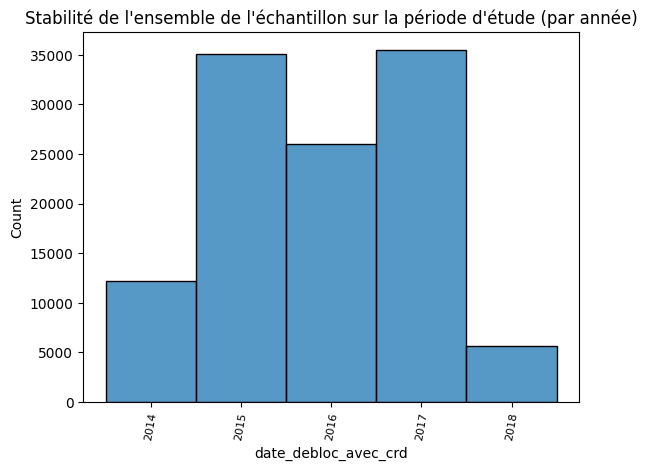

<Figure size 1400x1400 with 0 Axes>

In [7]:
stabilite_global_temps(raw_data)

Même si la base de données semble comporter des valeurs "extrêmes" (au delà de 3000 observations), il n'y a pas une distribution asymétrique entre les années (les données se comportent de la même façon au sein d'une année). On peut donc envisager un découpage hors-temps classique. Par année, le nombre d'observations peut  être différent mais cela peut être largement expliqué par le fait que les années ne sont pas complètes (pour 2014 et 2018).

In [8]:
""" Vérification des moyennes sur les potentielles Base Temps et Hors Temps """
print('base OOT :' , raw_data[raw_data["date_debloc_avec_crd"]>"2017-04-01"].mean()['defaut_36mois'] )
print('base principale :', raw_data[(raw_data["date_debloc_avec_crd"]<="2017-04-01") & (raw_data["date_debloc_avec_crd"]>= "2014-04-01"  ) ].mean()['defaut_36mois'] )



base OOT : 0.009738727530138573
base principale : 0.0063661409112362385


Les gens qui ont octroyé un prêt après 04/2017 ont eu plus de défaut sur cette période. On aura sûrement moins de facilité à trouver le défaut sachant que la base OOT a plus d'observations en moyenne comportant des défauts.
Remarque: une explication plausible du taux de défaut plus élevé pourraît être la crise de covid. En effet, les clients considérés à partir d'avril 2017 ont été observés jusqu'en avril 2021 (au max). Cela signifie, contrairement aux autres clients, qu'ils ont connu la crise du covid et la récession qui s'en suit. Peut-être, peut-on considérer base hors temps comme un choc inhabituel? 

#### Découpage de la base

- Découpage temps/hors temps (df_etude, df_hors_temps)
- Découpage base temps: échantillon d'apprentissage et de test (X_train, X_test)

##### Découpage temps/hors-temps

In [9]:
""" DECOUPAGE TEMPS/HORS TEMPS """
df_hors_temps=raw_data[raw_data["date_debloc_avec_crd"]>="2017-04-01"]
df_etude=raw_data[(raw_data["date_debloc_avec_crd"]<"2017-04-01") & (raw_data["date_debloc_avec_crd"]> "2014-04-01"  ) ]
print("Effectif base temps:", len(df_etude), " VS  Effectif base hors temps:",len(df_hors_temps) )


Effectif base temps: 85270  VS  Effectif base hors temps: 28037


Le découpage semble être plutôt approprié

##### Découpage Apprentissage/Test
Remarque: on utilise l'option stratify lors de la constitution des échantillons Train et Test de sorte à avoir un taux de défaut représentatif de l'ensemble de l'échantillon

In [10]:
""" DECOUPAGE APPRENTISSAGE/TEST """
X_train, X_test=train_test_split(df_etude,test_size=0.2 , stratify =df_etude['defaut_36mois'], random_state=42)


""" Vérification que le taux de défaut sur l'échantillon d'apprentissage et validation """
print("TAUX DE DEFAUT POUR LES DEUX ECHANTILLONS:")
print( 'train :' , X_train['defaut_36mois'].mean() * 100, " vs ",'test : ' , X_test['defaut_36mois'].mean()*100)


""" ISOLATION DE LA TARGET DU RESTE"""
y=X_train["defaut_36mois"].astype(int)
drop_columns(X_train,["defaut_36mois"])


TAUX DE DEFAUT POUR LES DEUX ECHANTILLONS:
train : 0.6435440365896563  vs  test :  0.6450099683358743
Ces colonnes vont être retirées: ['defaut_36mois']


region_cri date_debloc_avec_crd DAT_VALIDE_ACCORD_CRI  nb_pret  \
42120  HAUTS DE FRANCE           2015-09-01            2015-06-30        1   
39454  HAUTS DE FRANCE           2015-08-01            2015-06-12        1   
93820    ILE DE FRANCE           2017-03-01            2017-02-22        1   
59725        OCCITANIE           2016-06-01            2016-05-31        1   
21854        NORMANDIE           2015-04-01            2015-02-14        1   
...                ...                  ...                   ...      ...   
24306    ILE DE FRANCE           2015-05-01            2015-03-25        1   
51093    ILE DE FRANCE           2016-02-01            2016-01-05        1   
12050             PACA           2014-12-01            2014-10-28        1   
25978        GRAND EST           2015-05-01            2015-04-20        1   
33501    ILE DE FRANCE           2015-06-01            2015-05-15        1   

       TOP_CONNU_BRP  TOP_SCI_BRP  ASU_BIEN_FIN_BRP  NAT_BIEN_FIN_BRP  \
42120              0            0                10                20   
39454              0            0                10                20   
93820              0            0                10                10   
59725              0            0                10                20   
21854              0            0                10                20   
...              ...          ...               ...               ...   
24306              0            0                10                20   
51093              0            0                40                10   
12050              0            0                10                10   
25978              0            0                10                20   
33501              0            0                10                10   

       NBR_INT_BRP  NBR_TOT_COEMPR_CRI  ... Mt_credit_nb_ans_rev_prof  \
42120            1                   0  ...                  4.613043   
39454            2                   1  ...                  2.313638   
93820            1                   0  ...                  6.913040   
59725            2                   1  ...                  3.053078   
21854            2                   1  ...                  2.623172   
...            ...                 ...  ...                       ...   
24306            2                   1  ...                  3.607372   
51093            2                   1  ...                  2.693424   
12050            1                   0  ...                  4.427017   
25978            2                   1  ...                  3.254631   
33501            2                   1  ...                  5.904588   

       Epargne_nb_ans_rev_prof rentabilite_loc  financement_tot   quotite  \
42120                 1.033133             NaN        133953.00  1.047752   
39454                      NaN             NaN        124402.00  1.044009   
93820                 3.090307             NaN        240000.00  1.000000   
59725                      NaN             NaN        310046.14  1.021407   
21854                      NaN             NaN        116259.00  1.023938   
...                        ...             ...              ...       ...   
24306                 0.154517             NaN        210115.00  1.038781   
51093                 0.351810        0.039964        165888.00  1.070673   
12050                 0.632431             NaN         70000.00  0.736842   
25978                 0.099401             NaN        130969.62  1.028224   
33501                      NaN             NaN        264620.00  0.998566   

       top_locatif  top_pret_int_ext  top_autre_pret_int  top_autre_pret_ext  \
42120            0                 0                   0                   0   
39454            0                 0                   0                   0   
93820            0                 0                   0                   0   
59725            0                 0                   0                   0

L'échantillon test comporte pour l'instant 20% des observations et l'échantillon d'apprentissage 80%. Par ailleurs, on remarque le taux de défaut est quasiment égal (au millième près). La stratification de l'échantillon a été efficace. 

#### Carte des défauts

In [11]:
map=map_for_default_risk(df_geo)

# Preprocessing global
- Suppression des colonnes inutiles (indiquées par le métier ou considérées comme inutiles à la suite de l'analyse)
- Traitement des types 
- Valeurs manquantes



####

### Suppression de variables a priori
- TOP_GARANTIE_CL (indiqué sur la description des variables)
- ID n'est pas utilisable


### Traitement des types 

In [12]:
""" SUPPRESSION PRE-ANALYSE"""
unused_columns_for_analysis=['TOP_GARANTIE_CL',"ID"]
drop_columns(X_train,unused_columns_for_analysis)

Ces colonnes vont être retirées: ['TOP_GARANTIE_CL', 'ID']


region_cri date_debloc_avec_crd DAT_VALIDE_ACCORD_CRI  nb_pret  \
42120  HAUTS DE FRANCE           2015-09-01            2015-06-30        1   
39454  HAUTS DE FRANCE           2015-08-01            2015-06-12        1   
93820    ILE DE FRANCE           2017-03-01            2017-02-22        1   
59725        OCCITANIE           2016-06-01            2016-05-31        1   
21854        NORMANDIE           2015-04-01            2015-02-14        1   
...                ...                  ...                   ...      ...   
24306    ILE DE FRANCE           2015-05-01            2015-03-25        1   
51093    ILE DE FRANCE           2016-02-01            2016-01-05        1   
12050             PACA           2014-12-01            2014-10-28        1   
25978        GRAND EST           2015-05-01            2015-04-20        1   
33501    ILE DE FRANCE           2015-06-01            2015-05-15        1   

       TOP_CONNU_BRP  TOP_SCI_BRP  ASU_BIEN_FIN_BRP  NAT_BIEN_FIN_BRP  \
42120              0            0                10                20   
39454              0            0                10                20   
93820              0            0                10                10   
59725              0            0                10                20   
21854              0            0                10                20   
...              ...          ...               ...               ...   
24306              0            0                10                20   
51093              0            0                40                10   
12050              0            0                10                10   
25978              0            0                10                20   
33501              0            0                10                10   

       NBR_INT_BRP  NBR_TOT_COEMPR_CRI  ... Mt_credit_nb_ans_rev_prof  \
42120            1                   0  ...                  4.613043   
39454            2                   1  ...                  2.313638   
93820            1                   0  ...                  6.913040   
59725            2                   1  ...                  3.053078   
21854            2                   1  ...                  2.623172   
...            ...                 ...  ...                       ...   
24306            2                   1  ...                  3.607372   
51093            2                   1  ...                  2.693424   
12050            1                   0  ...                  4.427017   
25978            2                   1  ...                  3.254631   
33501            2                   1  ...                  5.904588   

      Epargne_nb_ans_rev_prof  rentabilite_loc  financement_tot   quotite  \
42120                1.033133              NaN        133953.00  1.047752   
39454                     NaN              NaN        124402.00  1.044009   
93820                3.090307              NaN        240000.00  1.000000   
59725                     NaN              NaN        310046.14  1.021407   
21854                     NaN              NaN        116259.00  1.023938   
...                       ...              ...              ...       ...   
24306                0.154517              NaN        210115.00  1.038781   
51093                0.351810         0.039964        165888.00  1.070673   
12050                0.632431              NaN         70000.00  0.736842   
25978                0.099401              NaN        130969.62  1.028224   
33501                     NaN              NaN        264620.00  0.998566   

       top_locatif  top_pret_int_ext  top_autre_pret_int  top_autre_pret_ext  \
42120            0                 0                   0                   0   
39454            0                 0                   0                   0   
93820            0                 0                   0                   0   
59725            0                 0                   0                   0

#### Variables de temps:
- On les supprime de l'analyse car ne sont pas forcément pertinente (ça aurait été le cas si on connaissait la date de tombée en défaut..)

In [13]:
""" SUPPRESSION DE VARIABLES DATETIME"""
X_train.drop(columns=date_columns,inplace=True)

#### Variables catégorielles

- On convertit les dummies en qualitatives
- On récupère la liste des variables catégorielles (présentes dans le lexique + celles qui sont géographiques..)
- On remarque que certaines variables sont en double, on regardera si certaines ont plus de NA que d'autres par la suite
- Les modalités sont souvent notées 1, 2, 3, etc... ==> Elles vont être lues comme numériques donc il faut les transformer en str (object)

In [14]:
""" TRAITEMENT DES DUMMIES"""
list_dummies=get_dummies_var(X_train)
print("Variables dummies: ",list_dummies)
convert_modalities_to_quali(X_train,list_dummies)

Variables dummies:  ['TOP_CONNU_BRP', 'TOP_SCI_BRP', 'TOP_ETR_BRP', 'TOP_PRET_RELAIS_BRP', 'TOP_SURFINANCEMENT_BRP', 'top_exist_conso_revo_BRP', 'TOP_ASC_DESC_BRP', 'ROL_INT_MAX_BRP', 'IND_INCIDENT_BDF_CRI', 'IND_PRIMO_ACCEDT_CRI', 'TOP_BIEN_FR_CRI', 'TOP_NAT_FR_CRI', 'top_locatif', 'top_pret_int_ext', 'top_autre_pret_int', 'top_autre_pret_ext', 'top_pers_seule']


region_cri  nb_pret TOP_CONNU_BRP TOP_SCI_BRP  ASU_BIEN_FIN_BRP  \
42120  HAUTS DE FRANCE        1             0           0                10   
39454  HAUTS DE FRANCE        1             0           0                10   
93820    ILE DE FRANCE        1             0           0                10   
59725        OCCITANIE        1             0           0                10   
21854        NORMANDIE        1             0           0                10   
...                ...      ...           ...         ...               ...   
24306    ILE DE FRANCE        1             0           0                10   
51093    ILE DE FRANCE        1             0           0                40   
12050             PACA        1             0           0                10   
25978        GRAND EST        1             0           0                10   
33501    ILE DE FRANCE        1             0           0                10   

       NAT_BIEN_FIN_BRP  NBR_INT_BRP  NBR_TOT_COEMPR_CRI COD_POSTAL_BIEN_CRI  \
42120                20            1                   0               62220   
39454                20            2                   1               59520   
93820                10            1                   0               95160   
59725                20            2                   1               31140   
21854                20            2                   1               76210   
...                 ...          ...                 ...                 ...   
24306                20            2                   1               94460   
51093                10            2                   1               94600   
12050                10            1                   0               06000   
25978                20            2                   1               10190   
33501                10            2                   1               78000   

      CODPAY_BIEN_CRI  ...  Mt_credit_nb_ans_rev_prof  \
42120             FRA  ...                   4.613043   
39454             FRA  ...                   2.313638   
93820             FRA  ...                   6.913040   
59725             FRA  ...                   3.053078   
21854             FRA  ...                   2.623172   
...               ...  ...                        ...   
24306             FRA  ...                   3.607372   
51093             FRA  ...                   2.693424   
12050             FRA  ...                   4.427017   
25978             FRA  ...                   3.254631   
33501             FRA  ...                   5.904588   

       Epargne_nb_ans_rev_prof  rentabilite_loc  financement_tot   quotite  \
42120                 1.033133              NaN        133953.00  1.047752   
39454                      NaN              NaN        124402.00  1.044009   
93820                 3.090307              NaN        240000.00  1.000000   
59725                      NaN              NaN        310046.14  1.021407   
21854                      NaN              NaN        116259.00  1.023938   
...                        ...              ...              ...       ...   
24306                 0.154517              NaN        210115.00  1.038781   
51093                 0.351810         0.039964        165888.00  1.070673   
12050                 0.632431              NaN         70000.00  0.736842   
25978                 0.099401              NaN        130969.62  1.028224   
33501                      NaN              NaN        264620.00  0.998566   

       top_locatif  top_pret_int_ext  top_autre_pret_int top_autre_pret_ext  \
42120            0                 0                   0                  0   
39454            0                 0                   0                  0   
93820            0                 0                   0                  0   
59725            0                 0                   0                  0   
21854            0                 0                   0                  0   
...   

In [15]:
""" CONVERSION VARIABLES CONTINUES QUI SONT DES VARIABLES CATEGORIELLES """
modalities_var=["TYP_CNT_TRA_MAX_BRP",
                "CODTYPE_PROJET_CRI",
                "COD_ETA_BIEN_CRI",
                "COD_USAGE_BIEN_CRI",
                "STA_CLP_BRP",
                "TYP_LOG_ACT_BRP",
                "QUA_INT_MAX_BRP",
                "ROL_INT_MAX_BRP",
                "CODTYP_CRT_TRAVAIL_CRI",
                "COD_SITU_LOGT_CRI",
                "COD_SIT_FAM_EMPRUNTEUR_CRI",
                "COD_TYPE_MARCHE_CRI",
                "NAT_BIEN_FIN_BRP",
                "SIT_FAM_INT_BRP",
                "COD_CPPOP_CRI", 
                "COD_CSP_BRP",
                "CSP_RGP_BRP",
                "ASU_BIEN_FIN_BRP",
                "CODTYPE_PROJET_CRI",
                "QUA_INT_1_BRP",
                "CODPAY_NAT_EMPRUNTEUR_CRI",
                "DEPARTEMENT_CRI",
                "COD_POSTAL_BIEN_CRI",
                "IRPAR_USAGE_V12_MAX",
                "IRPRO_USAGE_V12_MAX",
                "NBR_INT_BRP",
                "NBR_TOT_COEMPR_CRI",
                "NBR_ENF_ACHARGE_CRI",
                "NBR_OCCUP_CRI",

                ]  
                



convert_modalities_to_quali(X_train, modalities_var)


region_cri  nb_pret TOP_CONNU_BRP TOP_SCI_BRP ASU_BIEN_FIN_BRP  \
42120  HAUTS DE FRANCE        1             0           0               10   
39454  HAUTS DE FRANCE        1             0           0               10   
93820    ILE DE FRANCE        1             0           0               10   
59725        OCCITANIE        1             0           0               10   
21854        NORMANDIE        1             0           0               10   
...                ...      ...           ...         ...              ...   
24306    ILE DE FRANCE        1             0           0               10   
51093    ILE DE FRANCE        1             0           0               40   
12050             PACA        1             0           0               10   
25978        GRAND EST        1             0           0               10   
33501    ILE DE FRANCE        1             0           0               10   

      NAT_BIEN_FIN_BRP NBR_INT_BRP NBR_TOT_COEMPR_CRI COD_POSTAL_BIEN_CRI  \
42120               20           1                  0               62220   
39454               20           2                  1               59520   
93820               10           1                  0               95160   
59725               20           2                  1               31140   
21854               20           2                  1               76210   
...                ...         ...                ...                 ...   
24306               20           2                  1               94460   
51093               10           2                  1               94600   
12050               10           1                  0               06000   
25978               20           2                  1               10190   
33501               10           2                  1               78000   

      CODPAY_BIEN_CRI  ... Mt_credit_nb_ans_rev_prof Epargne_nb_ans_rev_prof  \
42120             FRA  ...                  4.613043                1.033133   
39454             FRA  ...                  2.313638                     NaN   
93820             FRA  ...                  6.913040                3.090307   
59725             FRA  ...                  3.053078                     NaN   
21854             FRA  ...                  2.623172                     NaN   
...               ...  ...                       ...                     ...   
24306             FRA  ...                  3.607372                0.154517   
51093             FRA  ...                  2.693424                0.351810   
12050             FRA  ...                  4.427017                0.632431   
25978             FRA  ...                  3.254631                0.099401   
33501             FRA  ...                  5.904588                     NaN   

      rentabilite_loc financement_tot   quotite  top_locatif  \
42120             NaN       133953.00  1.047752            0   
39454             NaN       124402.00  1.044009            0   
93820             NaN       240000.00  1.000000            0   
59725             NaN       310046.14  1.021407            0   
21854             NaN       116259.00  1.023938            0   
...               ...             ...       ...          ...   
24306             NaN       210115.00  1.038781            0   
51093        0.039964       165888.00  1.070673            1   
12050             NaN        70000.00  0.736842            0   
25978             NaN       130969.62  1.028224            0   
33501             NaN       264620.00  0.998566            0   

       top_pret_int_ext  top_autre_pret_int top_autre_pret_ext top_pers_seule  
42120                 0                   0                  0              1  
39454                 0                   0                  0              0  
93820                 0                   0                  0              1  
59725                 0                   0                  0              0  
21854               

### Valeurs manquantes

Ici, on a distingué trois types de valeurs manquantes: 
- si taux > 90% on vire ces variables
- si taux entre 20 % et 90 %, on a plusieurs possibilités:
    +  si SUM = NA correspond à une valeur nulle 
    +  sinon on fait la même chose pour les variables quali et quanti que pour les na faibles

In [16]:
df_missing_rate=missing_rate_report(X_train)

count       rate
FINANCEMENT_PR_BRP         67141  98.424123
SUM_MNT_PRE_INTERNE_BRP    66375  97.301220
TX_FINANCEMENT_AGENCE_BRP  66208  97.056409
TX_APPORT_AGENCE_BRP       66208  97.056409
TX_FINANCEMENT_BRP         66175  97.008033
...                          ...        ...
COUT_PROJET_HF_AT_BRP          0   0.000000
MNT_COUT_TOT_CREDIT_CRI        0   0.000000
PCT_TEG_TAEG_CRI               0   0.000000
PCT_NEGOC_CRI                  0   0.000000
top_pers_seule                 0   0.000000

[118 rows x 2 columns]

#### NA > 90%
On enlève les variables comportant trop de na cad supérieur à 90%

In [17]:
""" TRAITEMENT NA > 90%"""
high_na=df_missing_rate.index[df_missing_rate["rate"]> 90 ].tolist()
print("TRAITEMENT VALEURS MANQUANTES > 90%")
drop_columns(X_train,high_na)

TRAITEMENT VALEURS MANQUANTES > 90%
Ces colonnes vont être retirées: ['FINANCEMENT_PR_BRP', 'SUM_MNT_PRE_INTERNE_BRP', 'TX_FINANCEMENT_AGENCE_BRP', 'TX_APPORT_AGENCE_BRP', 'TX_FINANCEMENT_BRP', 'TX_APPORT_BRP', 'mnt_pret_ext_brp', 'SUM_LOYER_BRP', 'SUM_AUTRES_CHARG_BRP']


region_cri  nb_pret TOP_CONNU_BRP TOP_SCI_BRP ASU_BIEN_FIN_BRP  \
42120  HAUTS DE FRANCE        1             0           0               10   
39454  HAUTS DE FRANCE        1             0           0               10   
93820    ILE DE FRANCE        1             0           0               10   
59725        OCCITANIE        1             0           0               10   
21854        NORMANDIE        1             0           0               10   
...                ...      ...           ...         ...              ...   
24306    ILE DE FRANCE        1             0           0               10   
51093    ILE DE FRANCE        1             0           0               40   
12050             PACA        1             0           0               10   
25978        GRAND EST        1             0           0               10   
33501    ILE DE FRANCE        1             0           0               10   

      NAT_BIEN_FIN_BRP NBR_INT_BRP NBR_TOT_COEMPR_CRI COD_POSTAL_BIEN_CRI  \
42120               20           1                  0               62220   
39454               20           2                  1               59520   
93820               10           1                  0               95160   
59725               20           2                  1               31140   
21854               20           2                  1               76210   
...                ...         ...                ...                 ...   
24306               20           2                  1               94460   
51093               10           2                  1               94600   
12050               10           1                  0               06000   
25978               20           2                  1               10190   
33501               10           2                  1               78000   

      CODPAY_BIEN_CRI  ... Mt_credit_nb_ans_rev_prof Epargne_nb_ans_rev_prof  \
42120             FRA  ...                  4.613043                1.033133   
39454             FRA  ...                  2.313638                     NaN   
93820             FRA  ...                  6.913040                3.090307   
59725             FRA  ...                  3.053078                     NaN   
21854             FRA  ...                  2.623172                     NaN   
...               ...  ...                       ...                     ...   
24306             FRA  ...                  3.607372                0.154517   
51093             FRA  ...                  2.693424                0.351810   
12050             FRA  ...                  4.427017                0.632431   
25978             FRA  ...                  3.254631                0.099401   
33501             FRA  ...                  5.904588                     NaN   

      rentabilite_loc financement_tot   quotite  top_locatif  \
42120             NaN       133953.00  1.047752            0   
39454             NaN       124402.00  1.044009            0   
93820             NaN       240000.00  1.000000            0   
59725             NaN       310046.14  1.021407            0   
21854             NaN       116259.00  1.023938            0   
...               ...             ...       ...          ...   
24306             NaN       210115.00  1.038781            0   
51093        0.039964       165888.00  1.070673            1   
12050             NaN        70000.00  0.736842            0   
25978             NaN       130969.62  1.028224            0   
33501             NaN       264620.00  0.998566            0   

       top_pret_int_ext  top_autre_pret_int top_autre_pret_ext top_pers_seule  
42120                 0                   0                  0              1  
39454                 0                   0                  0              0  
93820                 0                   0                  0              1  
59725                 0                   0                  0              0  
21854               

#### NA < 90% 

On a fait plusieurs constats: 
- On a des variables catégorielles en double: intéressant de voir si une comporte plus de na que son doublon   / Démarche à faire pour quanti si il y a 
- SUM => Il semblerait que ces variables contiennent des na si c'est = 0 (épargne non renseignée = n'a pas d'épargne)
#

On propose une fonction qui :
- pour SUM => fill par 0
- pour variables catégorielles = imputation par mode
- pour variables quantitatives = imputation par médiane 

##### Traitement variables catégorielles en double et NaN
On remarque directement dans le lexique qu'il y a des variables en double. Si l'une des variables en doublons est plus complète qu'une autre, on a interêt à la garder 


In [18]:
""" TRAITEMENT DOUBLONS VARIABLES CATEGORIELLES POUR VALEURS MANQUANTES"""

dict_doublons={"NAT_BIEN_FIN_BRP" : "CODTYPE_PROJET_CRI",
                        "ASU_BIEN_FIN_BRP" : "COD_USAGE_BIEN_CRI",
                        "TYP_CNT_TRA_MAX_BRP" : "CODTYP_CRT_TRAVAIL_CRI",
                        "SIT_FAM_INT_BRP" : "COD_SIT_FAM_EMPRUNTEUR_CRI",
                        "TYP_LOG_ACT_BRP" : "COD_SITU_LOGT_CRI"
                        }
     
colonnes_doublons_to_drop=compare_na_variables_duplicates(X_train,dict_doublons)
drop_columns(X_train,colonnes_doublons_to_drop)


COMPARAISON NA POUR COLONNES EN DOUBLE
NAT_BIEN_FIN_BRP  VS  CODTYPE_PROJET_CRI
0  VS  0
ASU_BIEN_FIN_BRP  VS  COD_USAGE_BIEN_CRI
0  VS  0
TYP_CNT_TRA_MAX_BRP  VS  CODTYP_CRT_TRAVAIL_CRI
563  VS  563
SIT_FAM_INT_BRP  VS  COD_SIT_FAM_EMPRUNTEUR_CRI
0  VS  0
TYP_LOG_ACT_BRP  VS  COD_SITU_LOGT_CRI
0  VS  0
DONE
Ces colonnes vont être retirées: ['NAT_BIEN_FIN_BRP', 'ASU_BIEN_FIN_BRP', 'TYP_CNT_TRA_MAX_BRP', 'SIT_FAM_INT_BRP', 'TYP_LOG_ACT_BRP']


region_cri  nb_pret TOP_CONNU_BRP TOP_SCI_BRP NBR_INT_BRP  \
42120  HAUTS DE FRANCE        1             0           0           1   
39454  HAUTS DE FRANCE        1             0           0           2   
93820    ILE DE FRANCE        1             0           0           1   
59725        OCCITANIE        1             0           0           2   
21854        NORMANDIE        1             0           0           2   
...                ...      ...           ...         ...         ...   
24306    ILE DE FRANCE        1             0           0           2   
51093    ILE DE FRANCE        1             0           0           2   
12050             PACA        1             0           0           1   
25978        GRAND EST        1             0           0           2   
33501    ILE DE FRANCE        1             0           0           2   

      NBR_TOT_COEMPR_CRI COD_POSTAL_BIEN_CRI CODPAY_BIEN_CRI  \
42120                  0               62220             FRA   
39454                  1               59520             FRA   
93820                  0               95160             FRA   
59725                  1               31140             FRA   
21854                  1               76210             FRA   
...                  ...                 ...             ...   
24306                  1               94460             FRA   
51093                  1               94600             FRA   
12050                  0               06000             FRA   
25978                  1               10190             FRA   
33501                  1               78000             FRA   

      CODTYPE_PROJET_CRI COD_CPPOP_CRI  ... Mt_credit_nb_ans_rev_prof  \
42120                 20            70  ...                  4.613043   
39454                 20            70  ...                  2.313638   
93820                 10            10  ...                  6.913040   
59725                 20            70  ...                  3.053078   
21854                 20           130  ...                  2.623172   
...                  ...           ...  ...                       ...   
24306                 20            70  ...                  3.607372   
51093                 10            10  ...                  2.693424   
12050                 10            10  ...                  4.427017   
25978                 20           130  ...                  3.254631   
33501                 10            10  ...                  5.904588   

      Epargne_nb_ans_rev_prof  rentabilite_loc  financement_tot   quotite  \
42120                1.033133              NaN        133953.00  1.047752   
39454                     NaN              NaN        124402.00  1.044009   
93820                3.090307              NaN        240000.00  1.000000   
59725                     NaN              NaN        310046.14  1.021407   
21854                     NaN              NaN        116259.00  1.023938   
...                       ...              ...              ...       ...   
24306                0.154517              NaN        210115.00  1.038781   
51093                0.351810         0.039964        165888.00  1.070673   
12050                0.632431              NaN         70000.00  0.736842   
25978                0.099401              NaN        130969.62  1.028224   
33501                     NaN              NaN        264620.00  0.998566   

       top_locatif top_pret_int_ext top_autre_pret_int  top_autre_pret_ext  \
42120            0                0                  0                   0   
39454            0                0                  0                   0   
93820            0                0                  0                   0   
59725            0                0                  0                   0   
21854            0                0                  0                   0   
...            ...              ...                ...                 ...   
24306            0

#### NA > 20%
- On traite les na qui doivent avoir un traitement particulier cad qu'elles comportent bcp de na mais ne doivent pas être supprimé
- Remarque: On garde les variables de coût pour la suite

In [19]:
""" TRAITEMENT NA > 20 %"""
df_missing_rate=missing_rate_report(X_train)
missing_rate_sup_20=df_missing_rate.index[df_missing_rate["rate"]>20 ].tolist()
print("TRAITEMENT POUR VALEURS MANQUANTES >20%: ", missing_rate_sup_20)
variables_a_fill_0, variables_na_to_drop = na_sup_20_fill_by_0_vs_autres(missing_rate_sup_20)
print("Variables non supprimées: ",variables_a_fill_0)
fill_by_0(X_train, variables_a_fill_0)
drop_columns(X_train,variables_na_to_drop)


count       rate
rentabilite_loc          56795  83.257594
SUM_RESS_IMMO_BRP        56691  83.105137
COUT_NOTAIRE_BRP         39056  57.253430
COUT_ACQ_BRP             38234  56.048434
SUM_PATR_IMMO_BRP        35493  52.030315
...                        ...        ...
MNT_COUT_TOT_CREDIT_CRI      0   0.000000
PCT_TEG_TAEG_CRI             0   0.000000
PCT_NEGOC_CRI                0   0.000000
MNT_PRET_CRI                 0   0.000000
top_pers_seule               0   0.000000

[104 rows x 2 columns]

TRAITEMENT POUR VALEURS MANQUANTES >20%:  ['rentabilite_loc', 'SUM_RESS_IMMO_BRP', 'COUT_NOTAIRE_BRP', 'COUT_ACQ_BRP', 'SUM_PATR_IMMO_BRP', 'SUM_MTENCBIE_IMMO_BRP', 'SUM_MNT_PRE_EXTERNE_BRP', 'Epargne_nb_ans_rev_prof', 'SUM_EPARGNE_BRP', 'SUM_MTENCBIE_EPARGNE_BRP', 'SUM_TAX_FISC_BRP']
Variables non supprimées:  ['SUM_RESS_IMMO_BRP', 'COUT_NOTAIRE_BRP', 'COUT_ACQ_BRP', 'SUM_PATR_IMMO_BRP', 'SUM_MTENCBIE_IMMO_BRP', 'SUM_MNT_PRE_EXTERNE_BRP', 'SUM_EPARGNE_BRP', 'SUM_MTENCBIE_EPARGNE_BRP', 'SUM_TAX_FISC_BRP']
IMPUTATION PAR 0
OK
Ces colonnes vont être retirées: ['rentabilite_loc', 'Epargne_nb_ans_rev_prof']


region_cri  nb_pret TOP_CONNU_BRP TOP_SCI_BRP NBR_INT_BRP  \
42120  HAUTS DE FRANCE        1             0           0           1   
39454  HAUTS DE FRANCE        1             0           0           2   
93820    ILE DE FRANCE        1             0           0           1   
59725        OCCITANIE        1             0           0           2   
21854        NORMANDIE        1             0           0           2   
...                ...      ...           ...         ...         ...   
24306    ILE DE FRANCE        1             0           0           2   
51093    ILE DE FRANCE        1             0           0           2   
12050             PACA        1             0           0           1   
25978        GRAND EST        1             0           0           2   
33501    ILE DE FRANCE        1             0           0           2   

      NBR_TOT_COEMPR_CRI COD_POSTAL_BIEN_CRI CODPAY_BIEN_CRI  \
42120                  0               62220             FRA   
39454                  1               59520             FRA   
93820                  0               95160             FRA   
59725                  1               31140             FRA   
21854                  1               76210             FRA   
...                  ...                 ...             ...   
24306                  1               94460             FRA   
51093                  1               94600             FRA   
12050                  0               06000             FRA   
25978                  1               10190             FRA   
33501                  1               78000             FRA   

      CODTYPE_PROJET_CRI COD_CPPOP_CRI  ... TOP_NAT_FR_CRI CSP_RGP_BRP  \
42120                 20            70  ...              1         3.0   
39454                 20            70  ...              1         3.0   
93820                 10            10  ...              1         2.0   
59725                 20            70  ...              1         3.0   
21854                 20           130  ...              1         4.0   
...                  ...           ...  ...            ...         ...   
24306                 20            70  ...              1         3.0   
51093                 10            10  ...              1         2.0   
12050                 10            10  ...              1         5.0   
25978                 20           130  ...              1         5.0   
33501                 10            10  ...              1         5.0   

       Mt_credit_nb_ans_rev_prof  financement_tot   quotite  top_locatif  \
42120                   4.613043        133953.00  1.047752            0   
39454                   2.313638        124402.00  1.044009            0   
93820                   6.913040        240000.00  1.000000            0   
59725                   3.053078        310046.14  1.021407            0   
21854                   2.623172        116259.00  1.023938            0   
...                          ...              ...       ...          ...   
24306                   3.607372        210115.00  1.038781            0   
51093                   2.693424        165888.00  1.070673            1   
12050                   4.427017         70000.00  0.736842            0   
25978                   3.254631        130969.62  1.028224            0   
33501                   5.904588        264620.00  0.998566            0   

      top_pret_int_ext top_autre_pret_int  top_autre_pret_ext  top_pers_seule  
42120                0                  0                   0               1  
39454                0                  0                   0               0  
93820                0                  0                   0               1  
59725                0                  0                   0               0  
21854                0                  0                   0               0  
...                ...                ...                 ...             ...  
2430

#### NA faible (<20%)

In [20]:
""" TRAITEMENT DES VALEURS MANQUANTES POUR LES VARIABLES RESTANTES """
imputation_for_na(X_train)


IMPUTATION PAR MODE OU MEDIANE
OK


region_cri  nb_pret TOP_CONNU_BRP TOP_SCI_BRP NBR_INT_BRP  \
42120  HAUTS DE FRANCE        1             0           0           1   
39454  HAUTS DE FRANCE        1             0           0           2   
93820    ILE DE FRANCE        1             0           0           1   
59725        OCCITANIE        1             0           0           2   
21854        NORMANDIE        1             0           0           2   
...                ...      ...           ...         ...         ...   
24306    ILE DE FRANCE        1             0           0           2   
51093    ILE DE FRANCE        1             0           0           2   
12050             PACA        1             0           0           1   
25978        GRAND EST        1             0           0           2   
33501    ILE DE FRANCE        1             0           0           2   

      NBR_TOT_COEMPR_CRI COD_POSTAL_BIEN_CRI CODPAY_BIEN_CRI  \
42120                  0               62220             FRA   
39454                  1               59520             FRA   
93820                  0               95160             FRA   
59725                  1               31140             FRA   
21854                  1               76210             FRA   
...                  ...                 ...             ...   
24306                  1               94460             FRA   
51093                  1               94600             FRA   
12050                  0               06000             FRA   
25978                  1               10190             FRA   
33501                  1               78000             FRA   

      CODTYPE_PROJET_CRI COD_CPPOP_CRI  ... TOP_NAT_FR_CRI CSP_RGP_BRP  \
42120                 20            70  ...              1         3.0   
39454                 20            70  ...              1         3.0   
93820                 10            10  ...              1         2.0   
59725                 20            70  ...              1         3.0   
21854                 20           130  ...              1         4.0   
...                  ...           ...  ...            ...         ...   
24306                 20            70  ...              1         3.0   
51093                 10            10  ...              1         2.0   
12050                 10            10  ...              1         5.0   
25978                 20           130  ...              1         5.0   
33501                 10            10  ...              1         5.0   

       Mt_credit_nb_ans_rev_prof  financement_tot   quotite  top_locatif  \
42120                   4.613043        133953.00  1.047752            0   
39454                   2.313638        124402.00  1.044009            0   
93820                   6.913040        240000.00  1.000000            0   
59725                   3.053078        310046.14  1.021407            0   
21854                   2.623172        116259.00  1.023938            0   
...                          ...              ...       ...          ...   
24306                   3.607372        210115.00  1.038781            0   
51093                   2.693424        165888.00  1.070673            1   
12050                   4.427017         70000.00  0.736842            0   
25978                   3.254631        130969.62  1.028224            0   
33501                   5.904588        264620.00  0.998566            0   

      top_pret_int_ext top_autre_pret_int  top_autre_pret_ext  top_pers_seule  
42120                0                  0                   0               1  
39454                0                  0                   0               0  
93820                0                  0                   0               1  
59725                0                  0                   0               0  
21854                0                  0                   0               0  
...                ...                ...                 ...             ...  
2430

In [21]:
""" Vérification NA == 0 """

verif_valeurs_manquantes = X_train.isna().sum().sort_values()
print("Nombre de NaN:",verif_valeurs_manquantes)
print("TRAITEMENT DES VALEURS MANQUANTES: OK ")


Nombre de NaN: region_cri                    0
IND_PRIMO_ACCEDT_CRI          0
IND_INCIDENT_BDF_CRI          0
COD_TYPE_MARCHE_CRI           0
COD_SIT_FAM_EMPRUNTEUR_CRI    0
                             ..
MNT_PRET_CRI                  0
NBR_DUREE_TOT_PRET_CRI        0
top_exist_conso_revo_BRP      0
COUT_NOTAIRE_BRP              0
top_pers_seule                0
Length: 102, dtype: int64
TRAITEMENT DES VALEURS MANQUANTES: OK 


#### Feature engineering: Création de nouvelles variables


##### Variables proxys


In [22]:
""" Aperçu des bases"""
for df_name,df in dict_data_extern.items():
    display(df.head(10).style.set_caption(f"Aperçu de la base de l'indicateur '{df_name}'"))


On a deux types de jeu de données: 
- Un basé sur les codes postaux des communes
- L'autre sur les départements

On dispose des deux colonnes dans le dataframe de base, ce qui va nous permettre de réaliser facilement un merge:
- DEPARTEMENT_CRI

In [23]:
""" PREPROCESSING DES VARIABLES PROXYS """
X_proxys=X_train.copy()
proxys_processing(X_proxys,dict_data_extern)

In [24]:
proxys_var=["PRIX_LOYER","TAUX_CHOMAGE","TAUX_HLM"]

##### Croisement de variables
Nous avons fait le croisement de la variable COD_CPOP_CRI (type de projet) avec les coûts. On va combiner deux informations simultanément: 
- La nature du projet 
- Les coûts pour chaque type de projet

Selon le type de projet, les coûts peuvent être différents, il est donc important de remarquer cette information


In [25]:

COD_CPPOP_CRI={"10":"ACQUISITION_SEULE",
    "20":"ACQUISITION_TRAVAUX",
    "70":"RACHAT_DE_PRET",
    "30":"TERRAIN_CONSTRUCTION",
    "40":"CONSTRUCTION_SEULE",
    "60":"TRAVAUX",
    "50":"TRAVAUX_CONSTRUCTION",
    "80":"PAIEMENT_SOULTE",
    "90":"PAIEMENT_SOULTE_TRAVAUX",
    "110":"RACHAT_DE_PRET",
    "130":"RACHAT_DE_PRET"}
X_proxys["COD_CPPOP_CRI"]=X_proxys["COD_CPPOP_CRI"].map(COD_CPPOP_CRI)


In [26]:
""" Aperçu des coûts selon la modalité de CPPOP_CRI"""
list_costs=[
"COUT_ACQ_BRP",
"COUT_DOSSIER_BRP",
"COUT_GAR_BRP",
"COUT_NOTAIRE_BRP",
"AUTRES_COUT_BRP",
"COUT_PROJET_HF_AT_BRP",
"COUT_PROJET_HF_HT_BRP",
"COUT_PROJET_TF_AT_BRP",
"cout_projet_tf_ht_BRP",
"COUT_TRAVAUX_BRP",
"COUT_BIEN_FINANCE_BRP",
"COUT_BIEN_FINANCE_AGENCE_BRP",
"COUT_RACHAT_BRP",
"COUT_SOULTE_BRP"
]
for elem in X_proxys.COD_CPPOP_CRI.unique():
  df=X_proxys[list_costs][X_proxys["COD_CPPOP_CRI"]==elem]
  display(df.head(1).style.set_caption(elem))


In [27]:
encodage_cppop_cri={"ACQUISITION_SEULE": "ACQUISITION",
"RACHAT_DE_PRET": "RACHAT_PRET", 
"TRAVAUX": "TRAVAUX", 
"ACQUISITION_TRAVAUX": "TRAVAUX",
"PAIEMENT_SOULTE_TRAVAUX":  "TRAVAUX", 
"TERRAIN_CONSTRUCTION":  "TRAVAUX",
"PAIEMENT_SOULTE":  "TRAVAUX",
"CONSTRUCTION_SEULE": "TRAVAUX",
"TRAVAUX_CONSTRUCTION": "TRAVAUX"}
X_proxys["COD_CPPOP_CRI"]=X_proxys["COD_CPPOP_CRI"].map(encodage_cppop_cri)


On remarque que les variables COUT_BIEN_FINANCE_BRP & AUTRES_COUT_BRP comportent toute l'information des différentes colonnes. Ainsi, pour chaque modalité (selon un regroupement effectué plus tard dans l'analyse),on va récupérer la somme des coûts (COUT_BIEN_FINANCE_BRP & AUTRES_COUT_BRP). On testera ensuite leur significativité.



In [28]:
X_proxys,col_cross_var_mount=cross_variable_for_project_type(X_proxys)
display(test_kruskall_wallis(X_proxys[col_cross_var_mount+proxys_var],y).style.set_caption("Test de significativité pour les variables proxys et croisées"))


Nouvelles variables créées: ['ACQUISITION', 'RACHAT_PRET', 'TRAVAUX']


Les variables sont significatives, mais finalement, ne ressortent pas bien au Lasso. On a donc laissé cette analyse de façon indépendante à notre analyse principale. 

On enlève les colonnes géo et nationalité qui ne sont pas exploitables à notre sens

In [29]:
"""DROP VARIABLES GEOGRAPHIQUES """ 
list_geo_features=["region_cri","COD_POSTAL_BIEN_CRI","DEPARTEMENT_CRI","NAT_INT_MAX_BRP","CODPAY_NAT_EMPRUNTEUR_CRI","CODPAY_BIEN_CRI"]
drop_columns(X_train,list_geo_features)

Ces colonnes vont être retirées: ['region_cri', 'COD_POSTAL_BIEN_CRI', 'DEPARTEMENT_CRI', 'NAT_INT_MAX_BRP', 'CODPAY_NAT_EMPRUNTEUR_CRI', 'CODPAY_BIEN_CRI']


nb_pret TOP_CONNU_BRP TOP_SCI_BRP NBR_INT_BRP NBR_TOT_COEMPR_CRI  \
42120        1             0           0           1                  0   
39454        1             0           0           2                  1   
93820        1             0           0           1                  0   
59725        1             0           0           2                  1   
21854        1             0           0           2                  1   
...        ...           ...         ...         ...                ...   
24306        1             0           0           2                  1   
51093        1             0           0           2                  1   
12050        1             0           0           1                  0   
25978        1             0           0           2                  1   
33501        1             0           0           2                  1   

      CODTYPE_PROJET_CRI COD_CPPOP_CRI COD_ETA_BIEN_CRI COD_USAGE_BIEN_CRI  \
42120                 20            70               60                 10   
39454                 20            70               60                 10   
93820                 10            10               60                 10   
59725                 20            70               60                 10   
21854                 20           130               60                 10   
...                  ...           ...              ...                ...   
24306                 20            70               60                 10   
51093                 10            10               20                 40   
12050                 10            10               60                 10   
25978                 20           130               60                 10   
33501                 10            10               60                 10   

       BEST_APPORT_MT_BRP  ...  TOP_NAT_FR_CRI  CSP_RGP_BRP  \
42120            29695.28  ...               1          3.0   
39454            25598.00  ...               1          3.0   
93820                0.00  ...               1          2.0   
59725            51953.86  ...               1          3.0   
21854              741.00  ...               1          4.0   
...                   ...  ...             ...          ...   
24306            25885.00  ...               1          3.0   
51093            29695.28  ...               1          2.0   
12050            25000.00  ...               1          5.0   
25978            11117.38  ...               1          5.0   
33501              380.00  ...               1          5.0   

       Mt_credit_nb_ans_rev_prof financement_tot   quotite  top_locatif  \
42120                   4.613043       133953.00  1.047752            0   
39454                   2.313638       124402.00  1.044009            0   
93820                   6.913040       240000.00  1.000000            0   
59725                   3.053078       310046.14  1.021407            0   
21854                   2.623172       116259.00  1.023938            0   
...                          ...             ...       ...          ...   
24306                   3.607372       210115.00  1.038781            0   
51093                   2.693424       165888.00  1.070673            1   
12050                   4.427017        70000.00  0.736842            0   
25978                   3.254631       130969.62  1.028224            0   
33501                   5.904588       264620.00  0.998566            0   

       top_pret_int_ext  top_autre_pret_int  top_autre_pret_ext  \
42120                 0                   0                   0   
39454                 0                   0                   0   
93820                 0                   0                   0   
59725                 0                   0                   0   
21854                 0                   0                   0   
...                 ...                 ...                 ...   
24306                 0                   

### Etude univariée

#### Variables quantitatives: Point Biserial et Kruskal-Wallis 


In [30]:
df_point_bis=test_biserial(X_train,y)
df_kruskal=test_kruskall_wallis(X_train,y)


In [31]:
display(df_point_bis[df_point_bis['pvalue'] <= 0.05].sort_values(by="pvalue",ascending=False).style.set_caption("Variables significatives au sens du test Bisérial"))
display(df_kruskal[df_point_bis['pvalue'] <= 0.05].sort_values(by="pvalue",ascending=False).style.set_caption("Variables significatives au sens du test Kruskal-Wallis"))


#### Variables qualitatives: Chi2 et V de Cramer


In [32]:
""" PREMIERE SELECTION DE VARIABLES QUALITATIVES """ 
df_chi2=test_chi2_independance(X_train,y)
first_selection_qualitative=df_chi2["variable"][df_chi2["pvalue"]<0.1].tolist()

cramers_v_target=cramers_v_with_target(X_train[first_selection_qualitative],y)
cramer_all_quali=cramers_v_btw_X(X_train[first_selection_qualitative])


In [33]:
first_selection_qualitative=['COD_CPPOP_CRI',
 'COD_ETA_BIEN_CRI',
 'COD_USAGE_BIEN_CRI',
 'TOP_ETR_BRP',
 'TOP_PRET_RELAIS_BRP',
 'TOP_SURFINANCEMENT_BRP',
 'top_exist_conso_revo_BRP',
 'IRPAR_USAGE_V12_MAX',
 'IRPRO_USAGE_V12_MAX',
 'COD_CSP_BRP',
 'TOP_ASC_DESC_BRP',
 'QUA_INT_1_BRP',
 'QUA_INT_MAX_BRP',
 'CODTYP_CRT_TRAVAIL_CRI',
 'COD_SITU_LOGT_CRI',
 'COD_SIT_FAM_EMPRUNTEUR_CRI',
 'COD_TYPE_MARCHE_CRI',
 'IND_PRIMO_ACCEDT_CRI',
 'TOP_NAT_FR_CRI',
 'CSP_RGP_BRP',
 'top_pret_int_ext']

In [34]:
display(df_chi2[df_chi2['pvalue'] <= 0.1].sort_values(by="Chi2",ascending=False).style.set_caption( "Variables significatives au sens du Chi2"))
display(cramers_v_target.sort_values(by="coefficient",ascending=False).style.set_caption( "V de Cramer pour la target"))


In [35]:
display(cramers_v_btw_X(X_train[first_selection_qualitative]).style.highlight_between(left=60/100,right=98/100).set_caption("V de Cramer entre variables qualitatives"))

[INTERPRETATION CRAMER]

### Régression Lasso

[JUSTIFICATION]

In [36]:
""" PREMIERE SELECTION DE VARIABLE QUANTITATIVE """ 
first_selection_quantitative = selection_avec_lasso(X_train,y,20,'num')
print("Variables quantitatives sélectionnées par Lasso (seulement sur les variables quanti):",first_selection_quantitative)

coef
COUT_NOTAIRE_BRP         0.543696
PCT_TEG_TAEG_CRI         0.380638
AGE_INT_MAX_BRP          0.295196
SUM_MTENCBIE_IMMO_BRP    0.292370
MOY_ANC_PROF_BRP         0.244407
COUT_PROJET_HF_HT_BRP    0.236183
BEST_APPORT_TX_BRP       0.232984
PAR_SCI_BRP              0.222495
quotite                  0.212659
nb_pret                  0.200433
COUT_BIEN_FINANCE_BRP    0.189942
COUT_RACHAT_BRP          0.182819
COUT_TRAVAUX_BRP         0.180356
COUT_PROJET_HF_AT_BRP    0.178520
TX_APPORT_TF_AT_BRP      0.176739
NBR_AGE_CLIENT_CRI       0.173365
MNT_COUT_TOT_CREDIT_CRI  0.167751
cout_projet_tf_ht_BRP    0.167113
SUM_PATR_IMMO_BRP        0.159543
NBR_AUT_CHAR_BRP         0.145851

Variables quantitatives sélectionnées par Lasso (seulement sur les variables quanti): ['COUT_NOTAIRE_BRP', 'PCT_TEG_TAEG_CRI', 'AGE_INT_MAX_BRP', 'SUM_MTENCBIE_IMMO_BRP', 'MOY_ANC_PROF_BRP', 'COUT_PROJET_HF_HT_BRP', 'BEST_APPORT_TX_BRP', 'PAR_SCI_BRP', 'quotite', 'nb_pret', 'COUT_BIEN_FINANCE_BRP', 'COUT_RACHAT_BRP', 'COUT_TRAVAUX_BRP', 'COUT_PROJET_HF_AT_BRP', 'TX_APPORT_TF_AT_BRP', 'NBR_AGE_CLIENT_CRI', 'MNT_COUT_TOT_CREDIT_CRI', 'cout_projet_tf_ht_BRP', 'SUM_PATR_IMMO_BRP', 'NBR_AUT_CHAR_BRP']


Avant de poursuivre l'analyse avec ces variables, il faut s'assurer de la non-multicolinéarité des variables. En effet, il se peut que certaines variables perdent de l'importance (du poids) dans la régression du fait de la multicolinéarité. Par conséquent, on regarde la matrice de corrélation:

<AxesSubplot: >

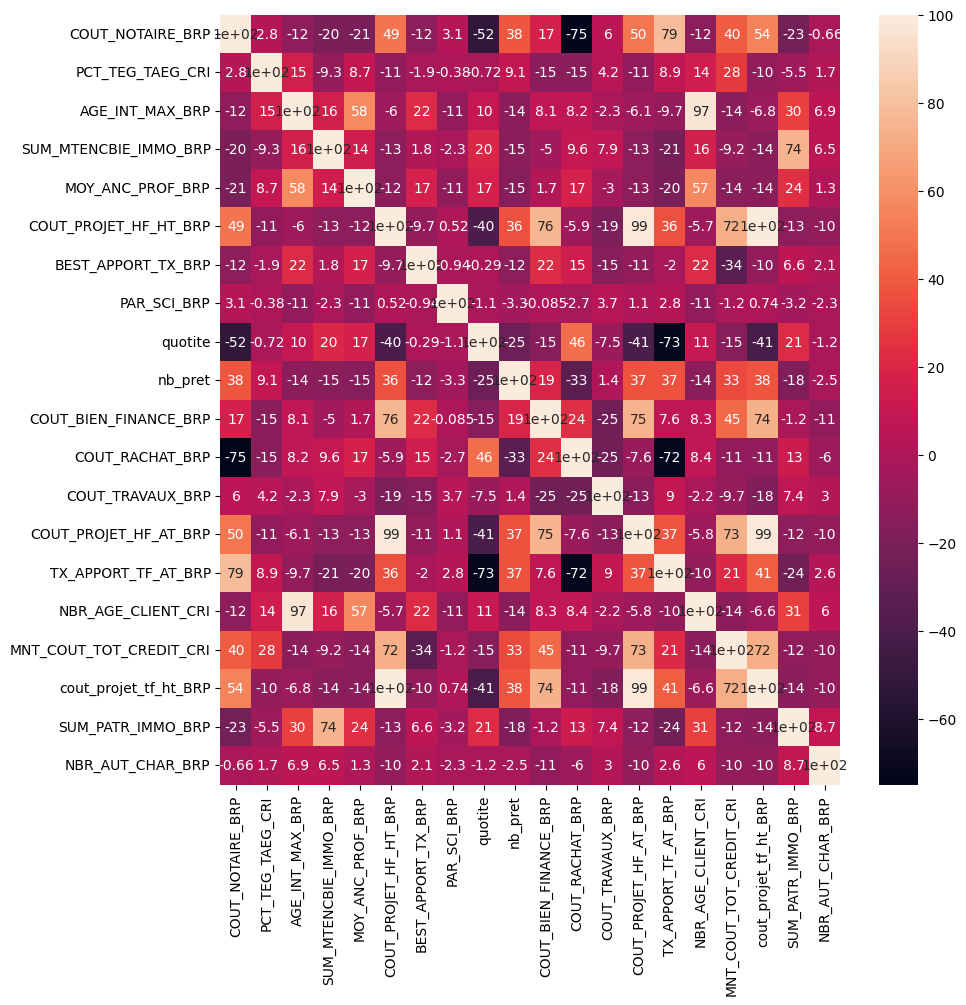

In [37]:
""" Détection de multicolinéarité: matrice de corrélation """
plt.figure(figsize = (10,10))
sns.heatmap(X_train[first_selection_quantitative].corr(method = 'spearman')*100 , annot = True) 


Plusieurs variables semblent générer de la multicolinéarité, on va donc les supprimer:
- [A COMPLETER]

In [38]:
first_selection_quantitative=['MNT_PRET_CRI','PCT_TEG_TAEG_CRI','nb_pret','BEST_APPORT_TX_BRP','COUT_NOTAIRE_BRP','SUM_PATR_IMMO_BRP','SUM_RESS_REVENUS_BRP','MOY_ANC_PROF_BRP','MNT_TOT_ASSURANCE_CRI','PAR_SCI_BRP',"SUM_MTENCBIE_IMMO_BRP",'AGE_INT_MAX_BRP','COUT_PROJET_HF_AT_BRP','MNT_COUT_TOT_CREDIT_CRI','quotite','COUT_RACHAT_BRP']

<AxesSubplot: >

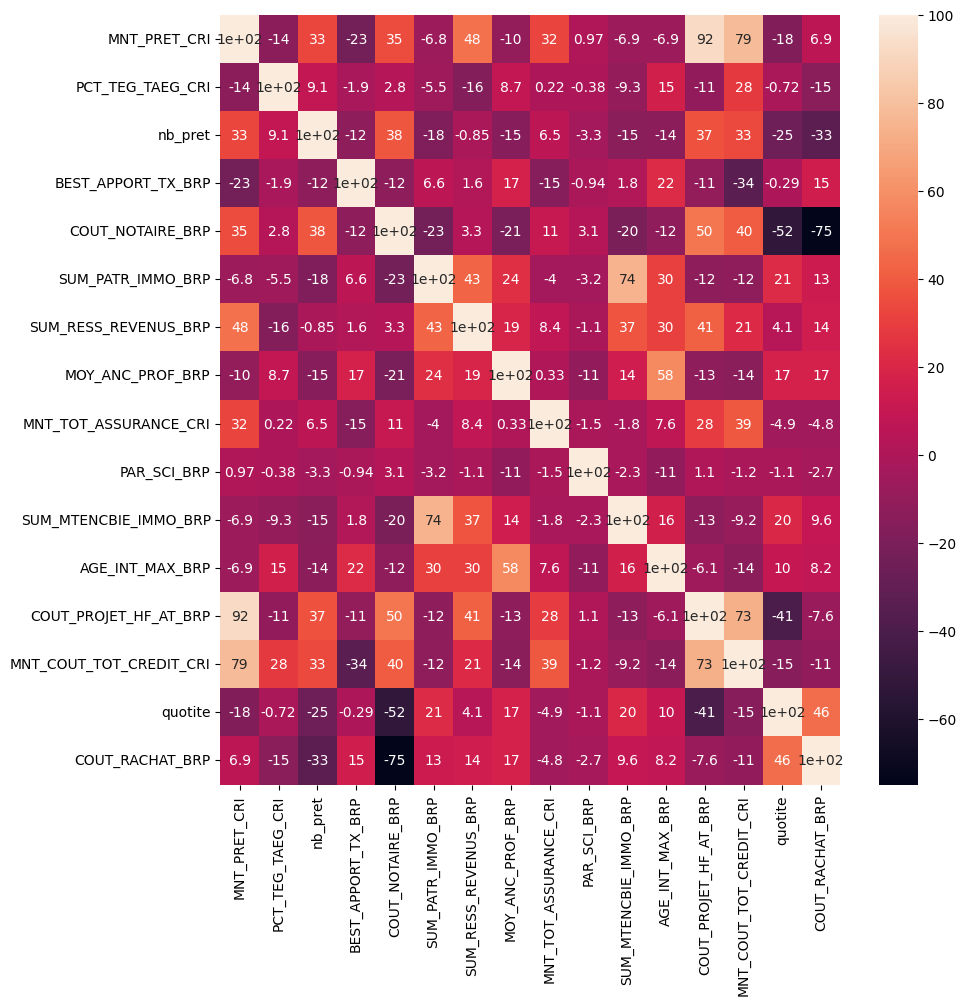

In [39]:
# heatmap apres suppressions des variables qui causent de la multi colinéarité 
plt.figure(figsize = (10,10))
sns.heatmap(X_train[first_selection_quantitative].corr(method = 'spearman')*100 , annot = True) 

#### Sur l'ensemble des variables:

In [40]:
""" Aperçu du Lasso sur l'ensemble (pas optimal pour avoir une vue générale des variables)"""

selection_avec_lasso(X_train,y,20,'all')


coef
IRPAR_USAGE_V12_MAX_8.0   1.043928
IRPAR_USAGE_V12_MAX_1.0   0.752383
IRPAR_USAGE_V12_MAX_2.0   0.510147
COD_SITU_LOGT_CRI_20.0    0.475043
COD_ETA_BIEN_CRI_20       0.469092
COD_SITU_LOGT_CRI_10.0    0.463618
COD_ETA_BIEN_CRI_60       0.413576
COD_CSP_BRP_5500.0        0.413306
IRPAR_USAGE_V12_MAX_3.0   0.376338
IRPAR_USAGE_V12_MAX_7.0   0.375575
CODTYP_CRT_TRAVAIL_CRI_4  0.375521
QUA_INT_1_BRP_3           0.359318
IRPRO_USAGE_V12_MAX_nan   0.295191
PCT_TEG_TAEG_CRI          0.277547
IND_PRIMO_ACCEDT_CRI_1.0  0.236208
AGE_INT_MAX_BRP           0.235812
COUT_RACHAT_BRP           0.231978
PCT_APPORT_PERS_CRI       0.231847
COD_SITU_LOGT_CRI_50.0    0.231268
NBR_AGE_CLIENT_CRI        0.226766

['IRPAR_USAGE_V12_MAX_8.0',
 'IRPAR_USAGE_V12_MAX_1.0',
 'IRPAR_USAGE_V12_MAX_2.0',
 'COD_SITU_LOGT_CRI_20.0',
 'COD_ETA_BIEN_CRI_20',
 'COD_SITU_LOGT_CRI_10.0',
 'COD_ETA_BIEN_CRI_60',
 'COD_CSP_BRP_5500.0',
 'IRPAR_USAGE_V12_MAX_3.0',
 'IRPAR_USAGE_V12_MAX_7.0',
 'CODTYP_CRT_TRAVAIL_CRI_4',
 'QUA_INT_1_BRP_3',
 'IRPRO_USAGE_V12_MAX_nan',
 'PCT_TEG_TAEG_CRI',
 'IND_PRIMO_ACCEDT_CRI_1.0',
 'AGE_INT_MAX_BRP',
 'COUT_RACHAT_BRP',
 'PCT_APPORT_PERS_CRI',
 'COD_SITU_LOGT_CRI_50.0',
 'NBR_AGE_CLIENT_CRI']

## Discrétisation  + regroupement de modalités 
Dans cette partie, on se charge de:
-  discrétiser les variables quantitatives en modalités 
-  réduire le nombre de modalités pour les variables qualitatives (trop de modalités ==> surapprentissage)

In [41]:
print("Les variables qualitatives sont:",first_selection_quantitative)
print()
print("Les variables quantitatives sont:",first_selection_qualitative)

Les variables qualitatives sont: ['MNT_PRET_CRI', 'PCT_TEG_TAEG_CRI', 'nb_pret', 'BEST_APPORT_TX_BRP', 'COUT_NOTAIRE_BRP', 'SUM_PATR_IMMO_BRP', 'SUM_RESS_REVENUS_BRP', 'MOY_ANC_PROF_BRP', 'MNT_TOT_ASSURANCE_CRI', 'PAR_SCI_BRP', 'SUM_MTENCBIE_IMMO_BRP', 'AGE_INT_MAX_BRP', 'COUT_PROJET_HF_AT_BRP', 'MNT_COUT_TOT_CREDIT_CRI', 'quotite', 'COUT_RACHAT_BRP']

Les variables quantitatives sont: ['COD_CPPOP_CRI', 'COD_ETA_BIEN_CRI', 'COD_USAGE_BIEN_CRI', 'TOP_ETR_BRP', 'TOP_PRET_RELAIS_BRP', 'TOP_SURFINANCEMENT_BRP', 'top_exist_conso_revo_BRP', 'IRPAR_USAGE_V12_MAX', 'IRPRO_USAGE_V12_MAX', 'COD_CSP_BRP', 'TOP_ASC_DESC_BRP', 'QUA_INT_1_BRP', 'QUA_INT_MAX_BRP', 'CODTYP_CRT_TRAVAIL_CRI', 'COD_SITU_LOGT_CRI', 'COD_SIT_FAM_EMPRUNTEUR_CRI', 'COD_TYPE_MARCHE_CRI', 'IND_PRIMO_ACCEDT_CRI', 'TOP_NAT_FR_CRI', 'CSP_RGP_BRP', 'top_pret_int_ext']


### Regroupement des modalités pour les variables catégorielles


#### Nécessaire de regrouper des modalités?
Sans exception, toutes les variables qualitatives sont catégorielles. On va regarder le nombre de modalités pour chacune d'entre elles


Certaines variables ont trop (surapprentissage) ou pas assez de modalités (nombre de modalités =1 => aucune discrimination):
- On ne traite pas la CSP avec bcp de modalités (l'autre variable CSP disponible est plus pertinente et a le bon nombre de modalité)
- la variable STA qui n'a pas de modalités interprétables
- ROL_INT_MAX n'a pas plus d'une modalité


In [42]:
drop_columns(X_train,["STA_CLP_BRP","ROL_INT_MAX_BRP","TOP_CONNU_BRP"]+X_train.drop(columns=first_selection_qualitative).select_dtypes(include="object").columns.tolist())

Ces colonnes vont être retirées: ['STA_CLP_BRP', 'ROL_INT_MAX_BRP', 'TOP_CONNU_BRP', 'TOP_CONNU_BRP', 'TOP_SCI_BRP', 'NBR_INT_BRP', 'NBR_TOT_COEMPR_CRI', 'CODTYPE_PROJET_CRI', 'STA_CLP_BRP', 'ROL_INT_MAX_BRP', 'IND_INCIDENT_BDF_CRI', 'NBR_ENF_ACHARGE_CRI', 'NBR_OCCUP_CRI', 'TOP_BIEN_FR_CRI', 'top_locatif', 'top_autre_pret_int', 'top_autre_pret_ext', 'top_pers_seule']


nb_pret COD_CPPOP_CRI COD_ETA_BIEN_CRI COD_USAGE_BIEN_CRI  \
42120        1            70               60                 10   
39454        1            70               60                 10   
93820        1            10               60                 10   
59725        1            70               60                 10   
21854        1           130               60                 10   
...        ...           ...              ...                ...   
24306        1            70               60                 10   
51093        1            10               20                 40   
12050        1            10               60                 10   
25978        1           130               60                 10   
33501        1            10               60                 10   

       BEST_APPORT_MT_BRP  BEST_APPORT_TX_BRP  PCT_APPORT_PERS_CRI  \
42120            29695.28               16.05                    0   
39454            25598.00               17.07                    0   
93820                0.00                0.00                    9   
59725            51953.86               14.35                    0   
21854              741.00                0.63                    0   
...                   ...                 ...                  ...   
24306            25885.00               10.97                    0   
51093            29695.28               16.05                    0   
12050            25000.00               26.32                   37   
25978            11117.38                7.82                    0   
33501              380.00                0.14                   10   

       PCT_ENDETTMT_CRI TOP_ETR_BRP TOP_PRET_RELAIS_BRP  ...  \
42120          40.63401           0                   0  ...   
39454          23.22205           0                   0  ...   
93820          39.54419           0                   0  ...   
59725          28.42581           0                   0  ...   
21854          27.56401           0                   0  ...   
...                 ...         ...                 ...  ...   
24306          41.75972           0                   0  ...   
51093          43.51566           0                   0  ...   
12050          28.28043           0                   0  ...   
25978          23.25185           0                   0  ...   
33501          36.19553           0                   0  ...   

       MNT_PRET_ENC_LCL_CRI  SUM_IMPO_REV_BRP  SUM_TAX_FISC_BRP  \
42120                   0.0             487.0            1200.0   
39454                   0.0            2640.0               0.0   
93820                   0.0            3770.0            2696.0   
59725                   0.0           13192.0            2710.0   
21854                   0.0               1.0             364.0   
...                     ...               ...               ...   
24306                   0.0            2101.0            1554.0   
51093                   0.0            5268.0            3000.0   
12050                   0.0             175.0               0.0   
25978                   0.0            1702.0            1800.0   
33501                   0.0            2073.0            1500.0   

       SUM_MNT_PRE_EXTERNE_BRP  TOP_NAT_FR_CRI  CSP_RGP_BRP  \
42120                   199.26               1          3.0   
39454                    96.00               1          3.0   
93820                     0.00               1          2.0   
59725                     0.00               1          3.0   
21854                   257.01               1          4.0   
...                        ...             ...          ...   
24306                   690.62               1          3.0   
51093                  1324.28               1          2.0   
12050                     0.00               1          5.0   
25978                     0.00               1          5.0   
33501                     0.00               1          5.0   

       Mt_credit_n

#### Regroupement des modalités

 Avant regroupement: On regarde si certaines sont déja non significatives. Si jamais on vient à toucher aux modalités, c'est important de vérifier que ce n'est pas l'encodage qui a fait ça


##### Regroupement des modalités manuellement
- On récupère la liste des variables ayant plus de 5 modalités: il s'agit d'un seuil arbitraire, qui selon nous, semble pertinent. En effet, lorsqu'il y a trop de modalités, qui ont, qui plus est, peu d'observations, il convient de les regrouper pour éviter du surapprentissage

La priorité est de traiter les variables ayant trop de modalités (>8). D'une part on va renommer les catégories et effectuer un rassemblement de certaines modalités à la main. Dans un second temps, on va procéder à une sélection automatique. A la fin, on aura l'ensemble des variables catégorielles qui ont encore plus d'une modalité. 

In [43]:
replace_encoding_by_real_labels(X_train)


nb_pret      COD_CPPOP_CRI                  COD_ETA_BIEN_CRI  \
42120        1     RACHAT_DE_PRET                 ancien_sup_10_ans   
39454        1     RACHAT_DE_PRET                 ancien_sup_10_ans   
93820        1  ACQUISITION_SEULE                 ancien_sup_10_ans   
59725        1     RACHAT_DE_PRET                 ancien_sup_10_ans   
21854        1     RACHAT_DE_PRET                 ancien_sup_10_ans   
...        ...                ...                               ...   
24306        1     RACHAT_DE_PRET                 ancien_sup_10_ans   
51093        1  ACQUISITION_SEULE  vente en état futur d'achèvement   
12050        1  ACQUISITION_SEULE                 ancien_sup_10_ans   
25978        1     RACHAT_DE_PRET                 ancien_sup_10_ans   
33501        1  ACQUISITION_SEULE                 ancien_sup_10_ans   

      COD_USAGE_BIEN_CRI  BEST_APPORT_MT_BRP  BEST_APPORT_TX_BRP  \
42120                 10            29695.28               16.05   
39454                 10            25598.00               17.07   
93820                 10                0.00                0.00   
59725                 10            51953.86               14.35   
21854                 10              741.00                0.63   
...                  ...                 ...                 ...   
24306                 10            25885.00               10.97   
51093                 40            29695.28               16.05   
12050                 10            25000.00               26.32   
25978                 10            11117.38                7.82   
33501                 10              380.00                0.14   

       PCT_APPORT_PERS_CRI  PCT_ENDETTMT_CRI TOP_ETR_BRP TOP_PRET_RELAIS_BRP  \
42120                    0          40.63401           0                   0   
39454                    0          23.22205           0                   0   
93820                    9          39.54419           0                   0   
59725                    0          28.42581           0                   0   
21854                    0          27.56401           0                   0   
...                    ...               ...         ...                 ...   
24306                    0          41.75972           0                   0   
51093                    0          43.51566           0                   0   
12050                   37          28.28043           0                   0   
25978                    0          23.25185           0                   0   
33501                   10          36.19553           0                   0   

       ...  MNT_PRET_ENC_LCL_CRI  SUM_IMPO_REV_BRP  SUM_TAX_FISC_BRP  \
42120  ...                   0.0             487.0            1200.0   
39454  ...                   0.0            2640.0               0.0   
93820  ...                   0.0            3770.0            2696.0   
59725  ...                   0.0           13192.0            2710.0   
21854  ...                   0.0               1.0             364.0   
...    ...                   ...               ...               ...   
24306  ...                   0.0            2101.0            1554.0   
51093  ...                   0.0            5268.0            3000.0   
12050  ...                   0.0             175.0               0.0   
25978  ...                   0.0            1702.0            1800.0   
33501  ...                   0.0            2073.0            1500.0   

       SUM_MNT_PRE_EXTERNE_BRP  TOP_NAT_FR_CRI  CSP_RGP_BRP  \
42120                   199.26               1          3.0   
39454                    96.00               1          3.0   
93820                     0.00               1          2.0   
59725                     0.00               1          3.0   
21854                   257.01               1          4.0   
...                        ...             ...          ...   
24306                   690.62               1          3.0   
51093  

#### Regroupement des modalités automatiquement
- On a crée un algorithme qui permet de rassembler les modalités si elles ne sont pas assez remplies ou ne sont pas significatives.
- Deux objectifs: diminuer nombre de modalités et vérifier leur pertinence
- Si une modalités comporte moins de 5% ==> on doit la merge avec une autre modalité = on tente par modalité ayant la moyenne la plus proche
- Si la variable la plus proche n'est pas plus importante, alors on prend la classe majoritaire

In [46]:
""" REGROUPEMENT DES MODALITES + CREATION D'UN JSON (UTILISE POUR LA PIPELINE POUR ENCODER DE LA MEME MANIERE ) """

dict_encoding=group_modalities_with_optbinning(X_train,y,first_selection_qualitative,0.05,0.001,encoding=True)

################################ COD_CPPOP_CRI ################################
STATUS : OPTIMAL


Bin  Count  Count (%)  \
0                                        [RACHAT_DE_PRET]  34539   0.506318   
1                                     [ACQUISITION_SEULE]  27600   0.404597   
2       [ACQUISITION_TRAVAUX, TRAVAUX, TERRAIN_CONSTRU...   6077   0.089085   
3                                                 Special      0   0.000000   
4                                                 Missing      0   0.000000   
Totals                                                     68216   1.000000   

        Non-event  Event  Event rate       WoE        IV        JS  
0           34409    130    0.003764   0.53906  0.114039  0.014085  
1           27382    218    0.007899 -0.206333  0.019103  0.002384  
2            5986     91    0.014974  -0.85316  0.101501  0.012316  
3               0      0    0.000000       0.0  0.000000  0.000000  
4               0      0    0.000000       0.0  0.000000  0.000000  
Totals      67777    439    0.006435            0.234643  0.028785

ENCODING...
################################ COD_ETA_BIEN_CRI ################################
STATUS : OPTIMAL


Bin  Count  Count (%)  \
0       [ancien_inf_10_ans, vente en état futur d'achè...  18639   0.273235   
1                                     [ancien_sup_10_ans]  47229   0.692345   
2       [neuf, contrat construction maison individuell...   2266   0.033218   
3                                                 Special      0   0.000000   
4                                                 Missing     82   0.001202   
Totals                                                     68216   1.000000   

        Non-event  Event  Event rate       WoE        IV        JS  
0           18566     73    0.003917  0.499149  0.053729  0.006647  
1           46883    346    0.007326 -0.130507  0.012585  0.001572  
2            2247     19    0.008385 -0.266566  0.002700  0.000336  
3               0      0    0.000000       0.0  0.000000  0.000000  
4              81      1    0.012195  -0.64503  0.000698  0.000086  
Totals      67777    439    0.006435            0.069712  0.008642

ENCODING...
################################ COD_USAGE_BIEN_CRI ################################
STATUS : OPTIMAL


Bin  Count  Count (%)  Non-event  Event  Event rate  \
0                   [40]  11609   0.170180      11550     59    0.005082   
1                   [10]  54427   0.797863      54064    363    0.006669   
2       [20, 50, 60, 30]   2180   0.031957       2163     17    0.007798   
3                Special      0   0.000000          0      0    0.000000   
4                Missing      0   0.000000          0      0    0.000000   
Totals                    68216   1.000000      67777    439    0.006435   

             WoE        IV        JS  
0       0.237425  0.008551  0.001066  
1      -0.035958  0.001050  0.000131  
2      -0.193441  0.001318  0.000164  
3            0.0  0.000000  0.000000  
4            0.0  0.000000  0.000000  
Totals            0.010919  0.001362

ENCODING...
################################ TOP_ETR_BRP ################################
STATUS : OPTIMAL


Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [0]  64867   0.950906      64466    401    0.006182  0.040453   
1           [1]   3349   0.049094       3311     38    0.011347 -0.572059   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals           68216   1.000000      67777    439    0.006435             

              IV        JS  
0       0.001525  0.000191  
1       0.021572  0.002660  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.023097  0.002851

ENCODING...
################################ TOP_PRET_RELAIS_BRP ################################
STATUS : OPTIMAL


Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [0]  67309   0.986704      66882    427    0.006344  0.014422   
1           [1]    907   0.013296        895     12    0.013230 -0.727562   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals           68216   1.000000      67777    439    0.006435             

              IV        JS  
0       0.000204  0.000025  
1       0.010280  0.001257  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.010484  0.001283

ENCODING...
################################ TOP_SURFINANCEMENT_BRP ################################
STATUS : OPTIMAL


Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [0]  57728   0.846253      57380    348    0.006028   0.06577   
1           [1]  10488   0.153747      10397     91    0.008677 -0.301066   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals           68216   1.000000      67777    439    0.006435             

              IV        JS  
0       0.003544  0.000443  
1       0.016224  0.002020  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.019768  0.002463

ENCODING...
################################ top_exist_conso_revo_BRP ################################
STATUS : OPTIMAL


Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [0]  52316   0.766917      52001    315    0.006021  0.066967   
1           [1]  15900   0.233083      15776    124    0.007799 -0.193515   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals           68216   1.000000      67777    439    0.006435             

              IV        JS  
0       0.003328  0.000416  
1       0.009617  0.001200  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.012945  0.001616

ENCODING...
################################ IRPAR_USAGE_V12_MAX ################################
STATUS : OPTIMAL


Bin  Count  Count (%)  \
0                                      [2.0, 3.0]  52203   0.765260   
1                                           [4.0]   5403   0.079204   
2       [6.0, 1.0, 5.0, 8.0, 7.0, nan, 9.0, 10.0]  10610   0.155535   
3                                         Special      0   0.000000   
4                                         Missing      0   0.000000   
Totals                                             68216   1.000000   

        Non-event  Event  Event rate       WoE        IV        JS  
0           51936    267    0.005115   0.23104  0.036522  0.004555  
1            5363     40    0.007403 -0.141079  0.001691  0.000211  
2           10478    132    0.012441 -0.665248  0.097185  0.011929  
3               0      0    0.000000       0.0  0.000000  0.000000  
4               0      0    0.000000       0.0  0.000000  0.000000  
Totals      67777    439    0.006435            0.135398  0.016695

ENCODING...
################################ IRPRO_USAGE_V12_MAX ################################
STATUS : OPTIMAL


Bin  Count  Count (%)  \
0                                                   [nan]  66859   0.980107   
1       [5.0, 1.0, 3.0, 7.0, 2.0, 4.0, 8.0, 6.0, 9.0, ...   1357   0.019893   
2                                                 Special      0   0.000000   
3                                                 Missing      0   0.000000   
Totals                                                     68216   1.000000   

        Non-event  Event  Event rate       WoE        IV        JS  
0           66443    416    0.006222  0.033936  0.001110  0.000139  
1            1334     23    0.016949 -0.979036  0.032024  0.003850  
2               0      0    0.000000       0.0  0.000000  0.000000  
3               0      0    0.000000       0.0  0.000000  0.000000  
Totals      67777    439    0.006435            0.033134  0.003989

ENCODING...
################################ COD_CSP_BRP ################################
STATUS : OPTIMAL


Bin  Count  Count (%)  \
0                                                [5100.0]   6562   0.096194   
1                                [3600.0, 5400.0, 4700.0]  37406   0.548346   
2                                        [6100.0, 5500.0]   9841   0.144262   
3       [3300.0, 4300.0, 4600.0, 2330.0, 4500.0, 5600....  14407   0.211197   
4                                                 Special      0   0.000000   
5                                                 Missing      0   0.000000   
Totals                                                     68216   1.000000   

        Non-event  Event  Event rate       WoE        IV        JS  
0            6532     30    0.004572  0.343792  0.009639  0.001199  
1           37188    218    0.005828  0.099768  0.005198  0.000649  
2            9747     94    0.009552 -0.398059  0.027989  0.003476  
3           14310     97    0.006733 -0.045476  0.000447  0.000056  
4               0      0    0.000000       0.0  0.000000  0.000000  
5               0      0    0.000000       0.0  0.000000  0.000000  
Totals      67777    439    0.006435            0.043272  0.005380

ENCODING...
################################ TOP_ASC_DESC_BRP ################################
STATUS : OPTIMAL


Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [0]  68083    0.99805      67648    435    0.006389  0.007248   
1           [1]    133    0.00195        129      4    0.030075 -1.565961   
2       Special      0    0.00000          0      0    0.000000       0.0   
3       Missing      0    0.00000          0      0    0.000000       0.0   
Totals           68216    1.00000      67777    439    0.006435             

              IV        JS  
0       0.000052  0.000007  
1       0.011288  0.001282  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.011340  0.001289

ENCODING...
################################ QUA_INT_1_BRP ################################
STATUS : OPTIMAL


Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0        [4, 2]  62543   0.916838      62152    391    0.006252  0.029152   
1           [3]   5110   0.074909       5063     47    0.009198 -0.359912   
2           [5]    563   0.008253        562      1    0.001776  1.292023   
3       Special      0   0.000000          0      0    0.000000       0.0   
4       Missing      0   0.000000          0      0    0.000000       0.0   
Totals           68216   1.000000      67777    439    0.006435             

              IV        JS  
0       0.000768  0.000096  
1       0.011647  0.001448  
2       0.007770  0.000909  
3       0.000000  0.000000  
4       0.000000  0.000000  
Totals  0.020185  0.002453

ENCODING...
################################ QUA_INT_MAX_BRP ################################
STATUS : OPTIMAL


Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [4]  12505   0.183315      12441     64    0.005118  0.230391   
1        [2, 3]  55148   0.808432      54774    374    0.006782 -0.052764   
2           [5]    563   0.008253        562      1    0.001776  1.292023   
3       Special      0   0.000000          0      0    0.000000       0.0   
4       Missing      0   0.000000          0      0    0.000000       0.0   
Totals           68216   1.000000      67777    439    0.006435             

              IV        JS  
0       0.008702  0.001085  
1       0.002310  0.000289  
2       0.007770  0.000909  
3       0.000000  0.000000  
4       0.000000  0.000000  
Totals  0.018783  0.002283

ENCODING...
################################ CODTYP_CRT_TRAVAIL_CRI ################################
STATUS : OPTIMAL


Bin  Count  Count (%)  \
0                      [fonctionnaire ou agent public]  11667   0.171030   
1                       [cdi et professions libérales]  54720   0.802158   
2       [chomage, retraités, inactifs, cdd et intérim]   1829   0.026812   
3                                              Special      0   0.000000   
4                                              Missing      0   0.000000   
Totals                                                  68216   1.000000   

        Non-event  Event  Event rate       WoE        IV        JS  
0           11621     46    0.003943  0.492449  0.032834  0.004063  
1           54344    376    0.006871 -0.065978  0.003608  0.000451  
2            1812     17    0.009295 -0.370506  0.004442  0.000552  
3               0      0    0.000000       0.0  0.000000  0.000000  
4               0      0    0.000000       0.0  0.000000  0.000000  
Totals      67777    439    0.006435            0.040885  0.005066

ENCODING...
################################ COD_SITU_LOGT_CRI ################################
STATUS : OPTIMAL


Bin  Count  Count (%)  \
0                   [propriétaire accédant, propriétaire]  45125   0.661502   
1                                       [locataire autre]  15810   0.231764   
2       [occupant gratuit, logement parents, locataire...   7261   0.106441   
3                                                 Special      0   0.000000   
4                                                 Missing     20   0.000293   
Totals                                                     68216   1.000000   

        Non-event  Event  Event rate       WoE        IV        JS  
0           44914    211    0.004676  0.321168  0.058464  0.007277  
1           15647    163    0.010310 -0.475194  0.066736  0.008264  
2            7199     62    0.008539 -0.284916  0.009976  0.001243  
3               0      0    0.000000       0.0  0.000000  0.000000  
4              17      3    0.150000 -3.304878  0.021756  0.001913  
Totals      67777    439    0.006435            0.156931  0.018697

ENCODING...
################################ COD_SIT_FAM_EMPRUNTEUR_CRI ################################
STATUS : OPTIMAL


Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       [3.0, 5.0, 1.0]  37967   0.556570      37747    220    0.005795   
1                 [2.0]  28916   0.423889      28707    209    0.007228   
2       [nan, 6.0, 4.0]   1333   0.019541       1323     10    0.007502   
3               Special      0   0.000000          0      0    0.000000   
4               Missing      0   0.000000          0      0    0.000000   
Totals                   68216   1.000000      67777    439    0.006435   

             WoE        IV        JS  
0       0.105555  0.005889  0.000736  
1      -0.116917  0.006142  0.000767  
2      -0.154407  0.000503  0.000063  
3            0.0  0.000000  0.000000  
4            0.0  0.000000  0.000000  
Totals            0.012534  0.001566

ENCODING...
################################ COD_TYPE_MARCHE_CRI ################################
STATUS : OPTIMAL


Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0          [M1]  63968   0.937727      63574    394    0.006159   0.04413   
1          [M2]   4248   0.062273       4203     45    0.010593 -0.502587   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals           68216   1.000000      67777    439    0.006435             

              IV        JS  
0       0.001787  0.000223  
1       0.020352  0.002518  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.022139  0.002741

ENCODING...
################################ IND_PRIMO_ACCEDT_CRI ################################
STATUS : OPTIMAL


Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0       [nan, 2.0]  55706   0.816612      55389    317    0.005691  0.123756   
1            [1.0]  12510   0.183388      12388    122    0.009752 -0.419016   
2          Special      0   0.000000          0      0    0.000000       0.0   
3          Missing      0   0.000000          0      0    0.000000       0.0   
Totals              68216   1.000000      67777    439    0.006435             

              IV        JS  
0       0.011773  0.001471  
1       0.039860  0.004946  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.051633  0.006417

ENCODING...
################################ TOP_NAT_FR_CRI ################################
STATUS : OPTIMAL


Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [1]  66079   0.968673      65666    413    0.006250   0.02941   
1           [0]   2137   0.031327       2111     26    0.012167 -0.642658   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals           68216   1.000000      67777    439    0.006435             

              IV        JS  
0       0.000826  0.000103  
1       0.018045  0.002218  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.018871  0.002321

ENCODING...
################################ CSP_RGP_BRP ################################
STATUS : OPTIMAL


Bin  Count  Count (%)  Non-event  Event  \
0                 [4.0, 3.0, 5.0]  60536   0.887416      60167    369   
1                           [6.0]   4680   0.068606       4637     43   
2       [2.0, 7.0, nan, 8.0, 1.0]   3000   0.043978       2973     27   
3                         Special      0   0.000000          0      0   
4                         Missing      0   0.000000          0      0   
Totals                             68216   1.000000      67777    439   

        Event rate       WoE        IV        JS  
0         0.006096  0.054604  0.002576  0.000322  
1         0.009188 -0.358856  0.010599  0.001318  
2         0.009000 -0.337989  0.005962  0.000742  
3         0.000000       0.0  0.000000  0.000000  
4         0.000000       0.0  0.000000  0.000000  
Totals    0.006435            0.019136  0.002381

ENCODING...
################################ top_pret_int_ext ################################
STATUS : OPTIMAL


Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [0]  64699   0.948443      64293    406    0.006275  0.025374   
1           [1]   3517   0.051557       3484     33    0.009383  -0.38005   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing      0   0.000000          0      0    0.000000       0.0   
Totals           68216   1.000000      67777    439    0.006435             

              IV        JS  
0       0.000603  0.000075  
1       0.009033  0.001122  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.009636  0.001198

ENCODING...


In [47]:
""" ENCODAGE VARIABLES CATEGORIELLES SELON LE DICTIONNAIRE"""
f = open("doc/encoding_categorical_variables.json")
dict_encoding=json.load(f)
encoding_categorical_variables(X_train,dict_encoding,first_selection_qualitative)


In [48]:
quali_selected_variables=['COD_CPPOP_CRI',
 'TOP_ETR_BRP',
 'TOP_PRET_RELAIS_BRP',
 'TOP_SURFINANCEMENT_BRP',
 'top_exist_conso_revo_BRP',
 'IRPAR_USAGE_V12_MAX',
 'IRPRO_USAGE_V12_MAX',
 'COD_CSP_BRP',
 'TOP_ASC_DESC_BRP',
 'QUA_INT_1_BRP',
 'QUA_INT_MAX_BRP',
 'CODTYP_CRT_TRAVAIL_CRI',
 'COD_SITU_LOGT_CRI',
 'COD_TYPE_MARCHE_CRI',
 'IND_PRIMO_ACCEDT_CRI',
 'TOP_NAT_FR_CRI',
 'CSP_RGP_BRP',
 'top_pret_int_ext']

In [49]:
no_discriminant_cat_var=selection_categorical_var_post_grouping(X_train[first_selection_qualitative],y,0.001)
print("Variables non significatives post-sélection:", no_discriminant_cat_var)
#drop_columns(X_train,no_discriminant_cat_var)

Variables non significatives post-sélection: ['COD_CSP_BRP', 'COD_SIT_FAM_EMPRUNTEUR_CRI', 'CSP_RGP_BRP']


### Discrétisation des variables quantitatives


In [50]:
discretisation_variables_from_chi2(X_train)


nb_pret COD_CPPOP_CRI COD_ETA_BIEN_CRI COD_USAGE_BIEN_CRI  \
42120        1             2                2                  0   
39454        1             2                2                  0   
93820        1             0                2                  0   
59725        1             2                2                  0   
21854        1             2                2                  0   
...        ...           ...              ...                ...   
24306        1             2                2                  0   
51093        1             0                1                  2   
12050        1             0                2                  0   
25978        1             2                2                  0   
33501        1             0                2                  0   

       BEST_APPORT_MT_BRP  BEST_APPORT_TX_BRP  PCT_APPORT_PERS_CRI  \
42120            29695.28               16.05                    0   
39454            25598.00               17.07                    0   
93820                0.00                0.00                    9   
59725            51953.86               14.35                    0   
21854              741.00                0.63                    0   
...                   ...                 ...                  ...   
24306            25885.00               10.97                    0   
51093            29695.28               16.05                    0   
12050            25000.00               26.32                   37   
25978            11117.38                7.82                    0   
33501              380.00                0.14                   10   

       PCT_ENDETTMT_CRI TOP_ETR_BRP TOP_PRET_RELAIS_BRP  ...  g_quotite  \
42120          40.63401           0                   0  ...      grp_3   
39454          23.22205           0                   0  ...      grp_3   
93820          39.54419           0                   0  ...      grp_4   
59725          28.42581           0                   0  ...      grp_1   
21854          27.56401           0                   0  ...      grp_1   
...                 ...         ...                 ...  ...        ...   
24306          41.75972           0                   0  ...      grp_1   
51093          43.51566           0                   0  ...      grp_3   
12050          28.28043           0                   0  ...      grp_1   
25978          23.25185           0                   0  ...      grp_1   
33501          36.19553           0                   0  ...      grp_4   

       g_PCT_TEG_TAEG_CRI  g_MOY_ANC_PROF_BRP  g_nb_pret  \
42120               grp_3               grp_1      grp_2   
39454               grp_2               grp_3      grp_2   
93820               grp_2               grp_2      grp_2   
59725               grp_3               grp_1      grp_2   
21854               grp_4               grp_2      grp_2   
...                   ...                 ...        ...   
24306               grp_3               grp_1      grp_2   
51093               grp_3               grp_2      grp_2   
12050               grp_3               grp_2      grp_2   
25978               grp_3               grp_2      grp_2   
33501               grp_3               grp_1      grp_2   

       g_MNT_COUT_TOT_CREDIT_CRI  g_BEST_APPORT_TX_BRP  \
42120                      grp_1                 grp_3   
39454                      grp_1                 grp_2   
93820                      grp_3                 grp_4   
59725                      grp_3                 grp_3   
21854                      grp_1                 grp_4   
...                          ...                   ...   
24306                      grp_2                 grp_2   
51093                      grp_3                 grp_3   
12050                      grp_1                 grp_2   
25978                      grp_2                 grp_2   
33501                      grp_3                 grp_4   

       g_COUT_PROJET_HF_AT_BRP

Vérification que la discrétisation est pertinente avec : 
- un groupby par moyenne de défaut pour chaque variable 
- un test du khi2 

In [51]:
check_mean_defaut_rate_per_category(X_train,y)

------ pour la variable g_MNT_TOT_ASSURANCE_CRI : 



g_MNT_TOT_ASSURANCE_CRI
grp_1    210
grp_2    115
grp_3    114
Name: 1, dtype: int64


------ pour la variable g_COUT_RACHAT_BRP : 



g_COUT_RACHAT_BRP
grp_1     86
grp_2     39
grp_3    314
Name: 1, dtype: int64


------ pour la variable g_SUM_PATR_IMMO_BRP : 



g_SUM_PATR_IMMO_BRP
grp_1     40
grp_2    399
Name: 1, dtype: int64


------ pour la variable g_quotite : 



g_quotite
grp_1    134
grp_2     50
grp_3    137
grp_4    118
Name: 1, dtype: int64


------ pour la variable g_PCT_TEG_TAEG_CRI : 



g_PCT_TEG_TAEG_CRI
grp_1     25
grp_2     83
grp_3    146
grp_4    185
Name: 1, dtype: int64


------ pour la variable g_MOY_ANC_PROF_BRP : 



g_MOY_ANC_PROF_BRP
grp_1    170
grp_2    100
grp_3    169
Name: 1, dtype: int64


------ pour la variable g_nb_pret : 



g_nb_pret
grp_1    116
grp_2    323
Name: 1, dtype: int64


------ pour la variable g_MNT_COUT_TOT_CREDIT_CRI : 



g_MNT_COUT_TOT_CREDIT_CRI
grp_1    158
grp_2    104
grp_3    177
Name: 1, dtype: int64


------ pour la variable g_BEST_APPORT_TX_BRP : 



g_BEST_APPORT_TX_BRP
grp_1     51
grp_2    102
grp_3    167
grp_4    119
Name: 1, dtype: int64


------ pour la variable g_COUT_PROJET_HF_AT_BRP : 



g_COUT_PROJET_HF_AT_BRP
grp_1     44
grp_2    328
grp_3     67
Name: 1, dtype: int64


------ pour la variable g_SUM_MTENCBIE_IMMO_BRP : 



g_SUM_MTENCBIE_IMMO_BRP
grp_1     42
grp_2     48
grp_3    349
Name: 1, dtype: int64


------ pour la variable g_MNT_PRET_CRI : 



g_MNT_PRET_CRI
grp_1     89
grp_2    273
grp_3     77
Name: 1, dtype: int64


------ pour la variable g_AGE_INT_MAX_BRP : 



g_AGE_INT_MAX_BRP
grp_1    319
grp_2    120
Name: 1, dtype: int64

In [52]:
quanti_selected_variables=X_train.select_dtypes(include=['object']).columns.tolist()
quanti_selected_variables_basename=[quanti[2:] for quanti in quanti_selected_variables ]
print('Colonnes sélectionnées (avec noms initiaux)',quanti_selected_variables_basename)

Colonnes sélectionnées (avec noms initiaux) ['MNT_TOT_ASSURANCE_CRI', 'COUT_RACHAT_BRP', 'SUM_PATR_IMMO_BRP', 'quotite', 'PCT_TEG_TAEG_CRI', 'MOY_ANC_PROF_BRP', 'nb_pret', 'MNT_COUT_TOT_CREDIT_CRI', 'BEST_APPORT_TX_BRP', 'COUT_PROJET_HF_AT_BRP', 'SUM_MTENCBIE_IMMO_BRP', 'MNT_PRET_CRI', 'AGE_INT_MAX_BRP']


## Overview de la sélection de variables
- Quelles sont les variables finalement retenues?
- Etude de la stabilité temporelles
 

In [53]:
quali_selected_variables

['COD_CPPOP_CRI',
 'TOP_ETR_BRP',
 'TOP_PRET_RELAIS_BRP',
 'TOP_SURFINANCEMENT_BRP',
 'top_exist_conso_revo_BRP',
 'IRPAR_USAGE_V12_MAX',
 'IRPRO_USAGE_V12_MAX',
 'COD_CSP_BRP',
 'TOP_ASC_DESC_BRP',
 'QUA_INT_1_BRP',
 'QUA_INT_MAX_BRP',
 'CODTYP_CRT_TRAVAIL_CRI',
 'COD_SITU_LOGT_CRI',
 'COD_TYPE_MARCHE_CRI',
 'IND_PRIMO_ACCEDT_CRI',
 'TOP_NAT_FR_CRI',
 'CSP_RGP_BRP',
 'top_pret_int_ext']

In [54]:
X_train_selection=X_train[quali_selected_variables+quanti_selected_variables]

### Random Forest: sélection de variables finales
Cela va nous permettre d'avoir des variables encore plus discriminantes pour l'algorithme final


{'class_weight': 'balanced', 'max_depth': 3, 'min_samples_leaf': 100, 'n_estimators': 400}


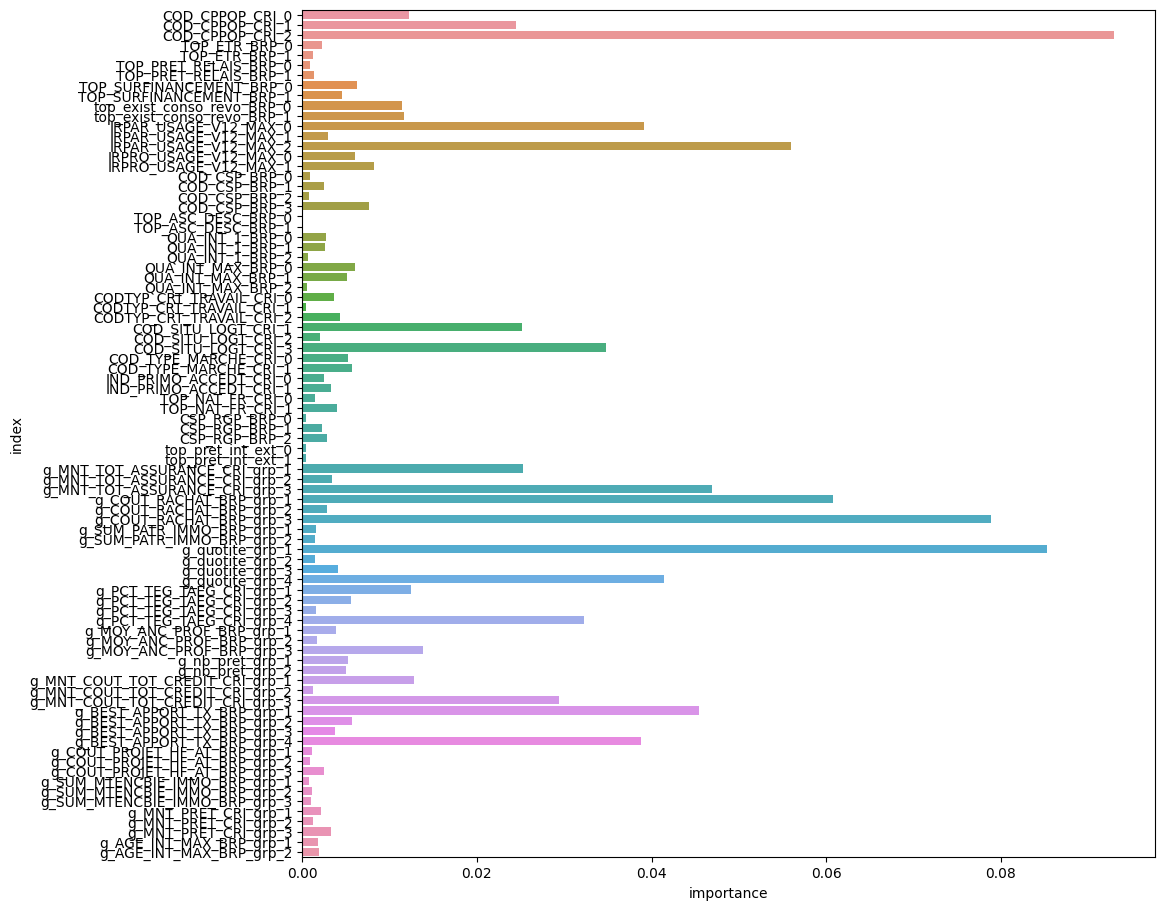

In [56]:
rf_plot=get_feature_selection_rf(X_train_selection,y)


Ainsi, parmi les variables présentées, nous allons garder les suivantes et supprimer les autres. 
[A COMPLETER]

In [57]:
""" Liste exhaustive de colonnes à enlever post-rf """

unselected_columns_for_model=['g_AGE_INT_MAX_BRP',
'g_MNT_PRET_CRI', 
'g_SUM_MTENCBIE_IMMO_BRP', 
'g_COUT_PROJET_HF_AT_BRP',
'TOP_ETR_BRP', 
'TOP_PRET_RELAIS_BRP', 
'TOP_SURFINANCEMENT_BRP' ,
'top_exist_conso_revo_BRP', 
'COD_CSP_BRP',
'CSP_RGP_BRP',
'TOP_ASC_DESC_BRP',
'g_SUM_PATR_IMMO_BRP',
'g_MNT_COUT_TOT_CREDIT_CRI',
'g_nb_pret',
'top_pret_int_ext']


X_selected_with_rf=X_train_selection.drop(columns =unselected_columns_for_model )

In [58]:
selected_variables=X_selected_with_rf.columns.tolist()

In [59]:
selected_variables

['COD_CPPOP_CRI',
 'IRPAR_USAGE_V12_MAX',
 'IRPRO_USAGE_V12_MAX',
 'QUA_INT_1_BRP',
 'QUA_INT_MAX_BRP',
 'CODTYP_CRT_TRAVAIL_CRI',
 'COD_SITU_LOGT_CRI',
 'COD_TYPE_MARCHE_CRI',
 'IND_PRIMO_ACCEDT_CRI',
 'TOP_NAT_FR_CRI',
 'g_MNT_TOT_ASSURANCE_CRI',
 'g_COUT_RACHAT_BRP',
 'g_quotite',
 'g_PCT_TEG_TAEG_CRI',
 'g_MOY_ANC_PROF_BRP',
 'g_BEST_APPORT_TX_BRP']

On doit toujours retrouver cette liste:

['COD_CPPOP_CRI',
 'IRPAR_USAGE_V12_MAX',
 'IRPRO_USAGE_V12_MAX',
 'QUA_INT_1_BRP',
 'QUA_INT_MAX_BRP',
 'CODTYP_CRT_TRAVAIL_CRI',
 'COD_TYPE_MARCHE_CRI',
 'IND_PRIMO_ACCEDT_CRI',
 'TOP_NAT_FR_CRI',
 'g_MNT_TOT_ASSURANCE_CRI',
 'g_COUT_RACHAT_BRP',
 'g_quotite',
 'g_PCT_TEG_TAEG_CRI',
 'g_MOY_ANC_PROF_BRP',
 'g_BEST_APPORT_TX_BRP',
 'COD_SITU_LOGT_CRI']

Avant de finir ce notebook sur la partie processing, nous allons vérifier la stabilité temporelle de nos features.
A cette occasion, nous allons vous présenter notre pipeline de preprocessing, qui permet de récupérer l'échantillon pré-processé comme l'échantillon d'apprentissage

[STABILITE TEMPORELLE]

### Stabilité temporelle
Application de la pipeline 'preprocessing_pipeline' qui: 

- Variables quantitatives à processer: quanti_selected_variables_basename
- Variables qualitatives à processer quali: quali_selected_variables
- Variables retenues après RF (noms avec gr): selected_variables

In [60]:
stability_data = raw_data.copy() 
y_for_stability=stability_data["defaut_36mois"]
x_for_stability=stability_data.drop(columns="defaut_36mois")
oot_base_clean=df_hors_temps.copy()
y_oot_base_clean=oot_base_clean["defaut_36mois"]
x_oot_base=oot_base_clean.drop(columns="defaut_36mois")
test=X_test.copy()
y_test_clean=test["defaut_36mois"]
x_test=test.drop(columns="defaut_36mois")

In [62]:
stability_data=pipeline_processing(x_for_stability, y_for_stability,quanti_selected_variables_basename,quali_selected_variables,selected_variables,stability_sample=True, training_option=False )

IMPUTATION PAR 0
OK
IMPUTATION PAR MODE OU MEDIANE
OK
DONE
DONE
Check COD_ETA_BIEN_CRI is selected
DONE
Ces colonnes vont être retirées: ['MNT_TOT_ASSURANCE_CRI', 'COUT_RACHAT_BRP', 'SUM_PATR_IMMO_BRP', 'quotite', 'PCT_TEG_TAEG_CRI', 'MOY_ANC_PROF_BRP', 'nb_pret', 'MNT_COUT_TOT_CREDIT_CRI', 'BEST_APPORT_TX_BRP', 'COUT_PROJET_HF_AT_BRP', 'SUM_MTENCBIE_IMMO_BRP', 'MNT_PRET_CRI', 'AGE_INT_MAX_BRP']
DONE


In [63]:
stability_data.to_csv("for_stability.csv")

STABILITE DES MODALITES PAR RAPPORT A LA TARGET
STABILITE DES MODALITES PAR RAPPORT AU TAUX DE DEFAUT
COD_CPPOP_CRI


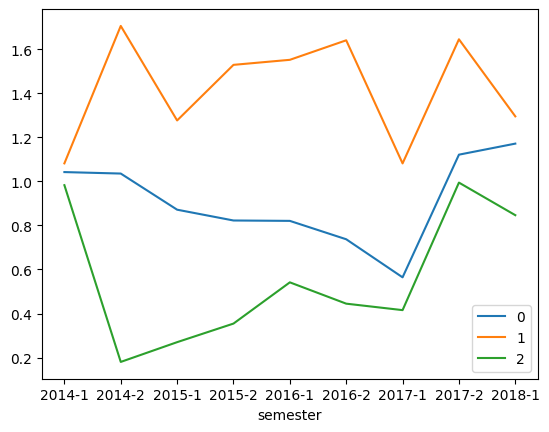

IRPAR_USAGE_V12_MAX


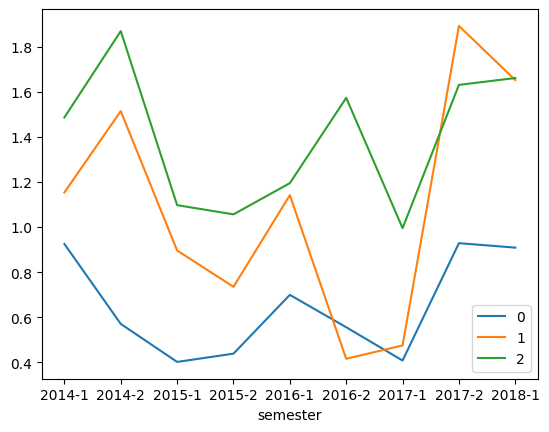

IRPRO_USAGE_V12_MAX


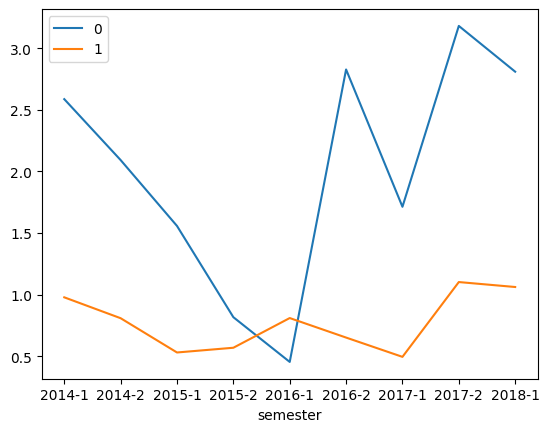

QUA_INT_1_BRP


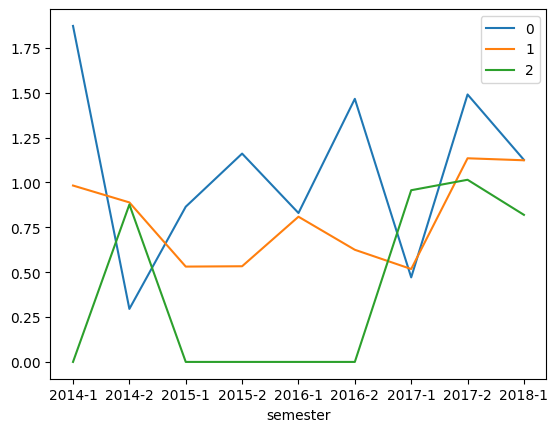

QUA_INT_MAX_BRP


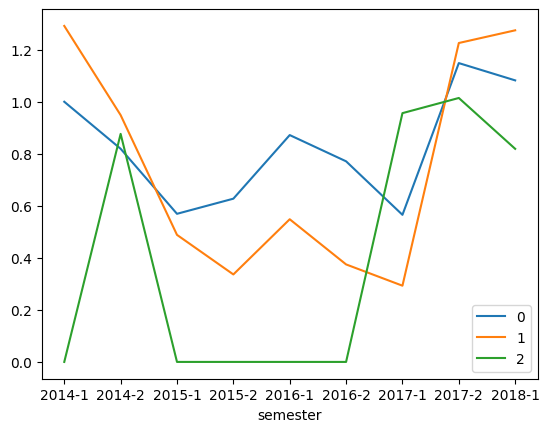

CODTYP_CRT_TRAVAIL_CRI


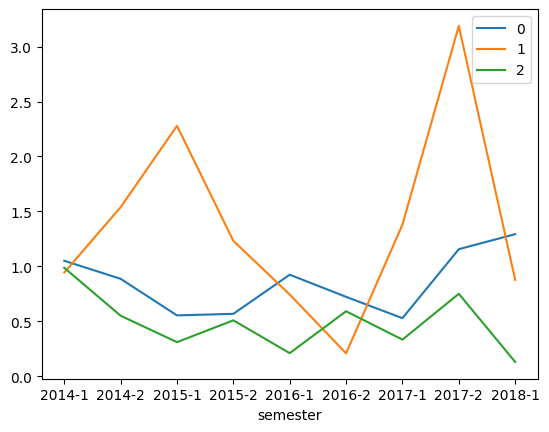

COD_SITU_LOGT_CRI


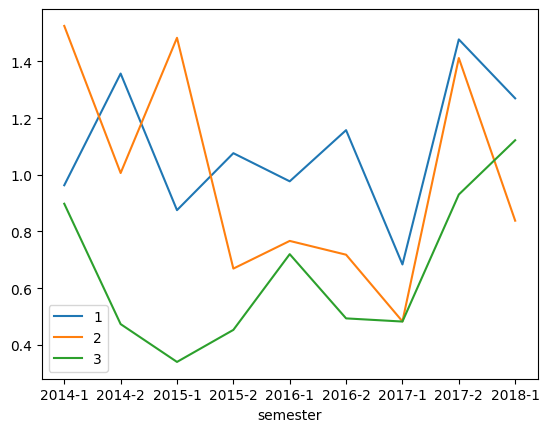

COD_TYPE_MARCHE_CRI


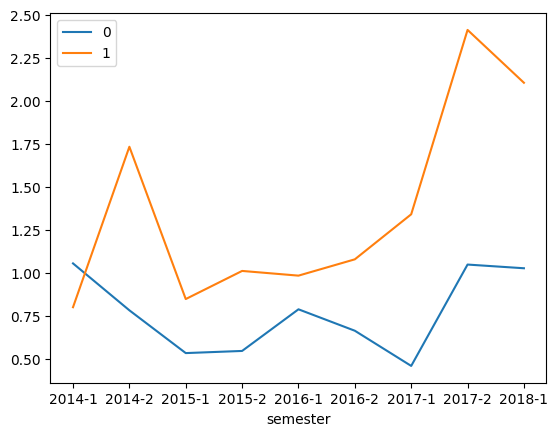

IND_PRIMO_ACCEDT_CRI


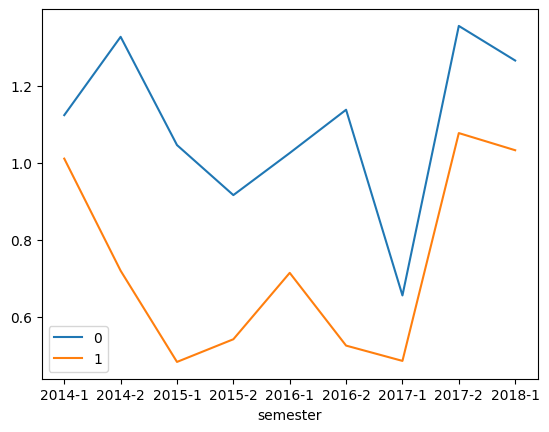

TOP_NAT_FR_CRI


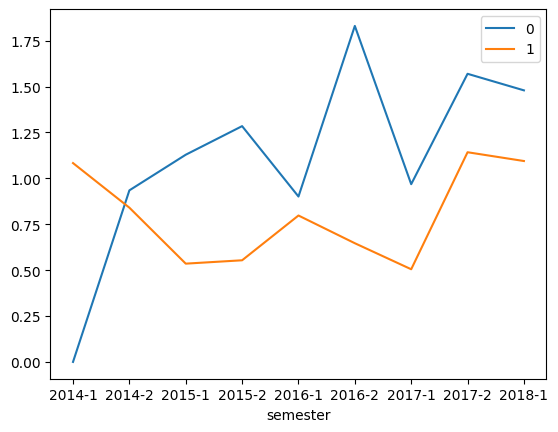

g_MNT_TOT_ASSURANCE_CRI


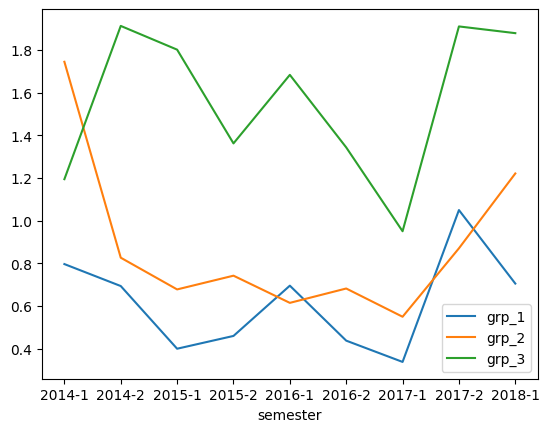

g_COUT_RACHAT_BRP


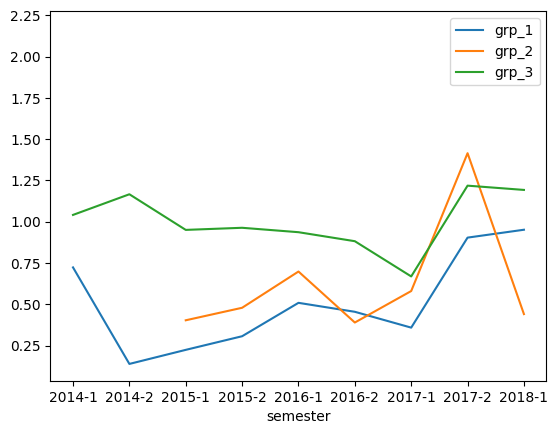

g_quotite


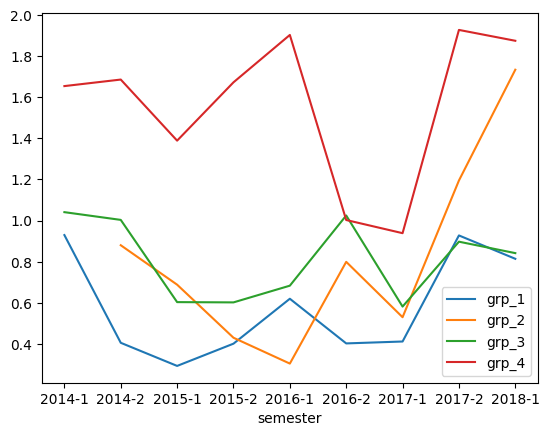

g_PCT_TEG_TAEG_CRI


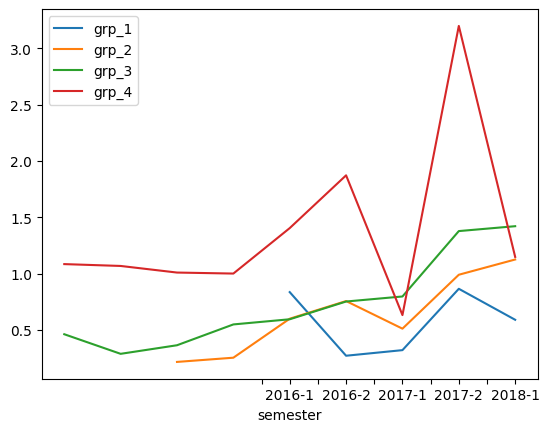

g_MOY_ANC_PROF_BRP


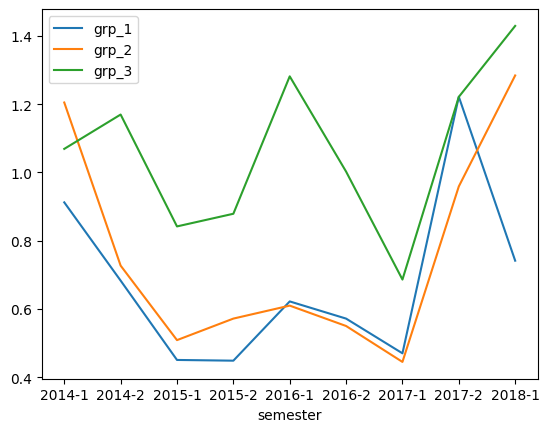

g_BEST_APPORT_TX_BRP


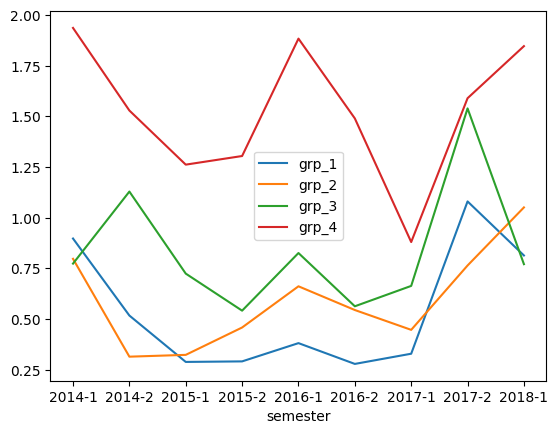

STABILITE DE LA REPARTITION DES MODALITES SELON LE TAUX DE DEFAUT


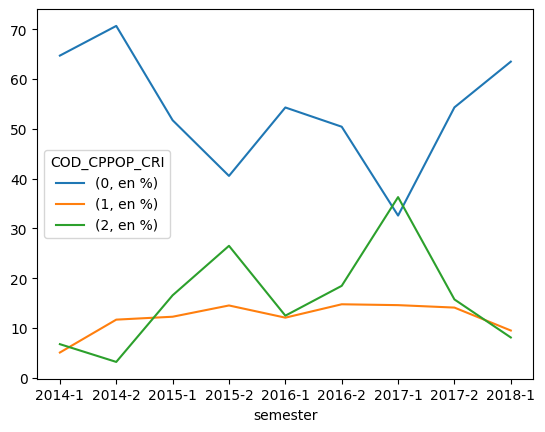

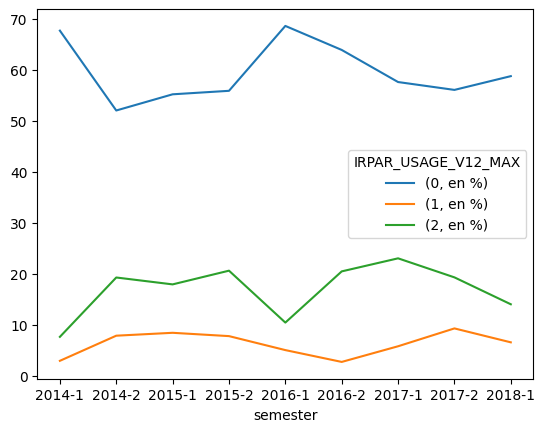

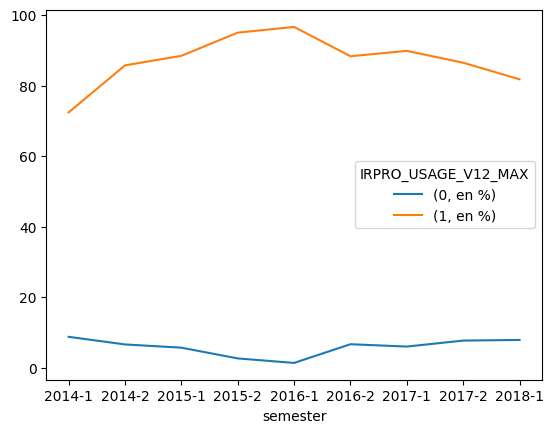

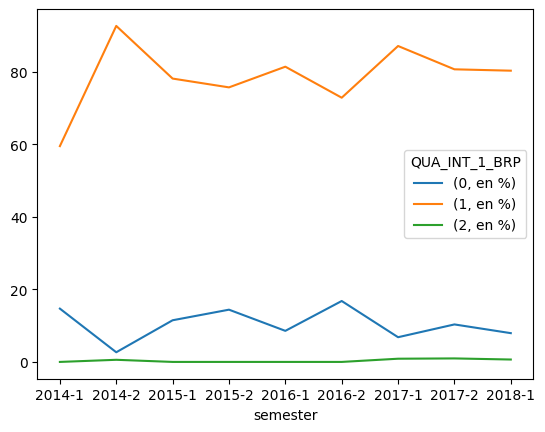

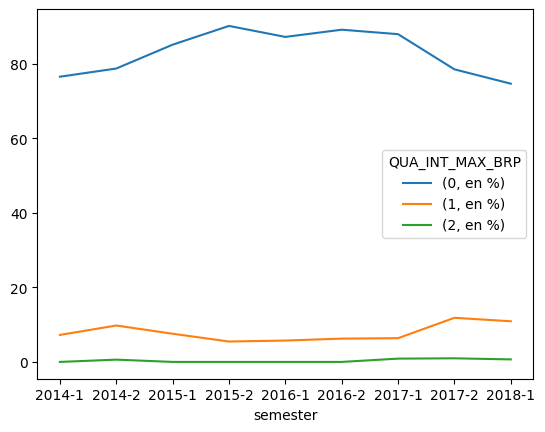

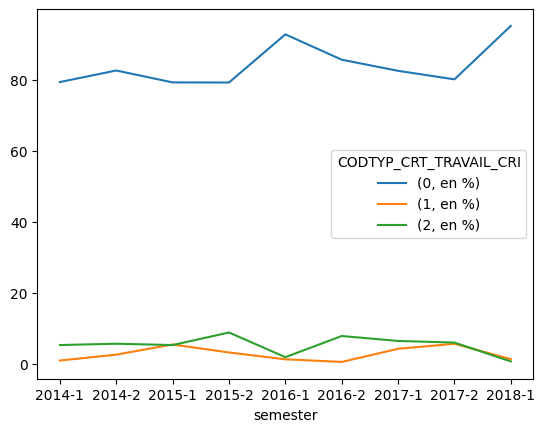

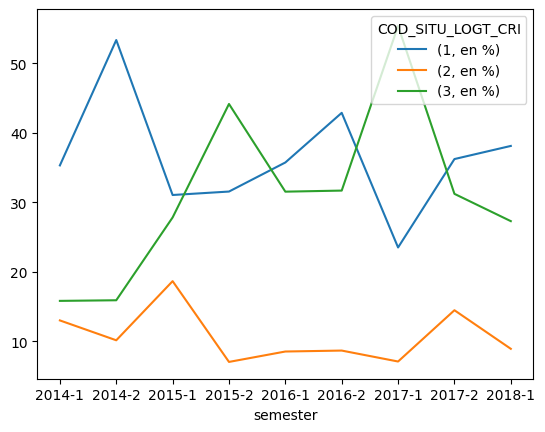

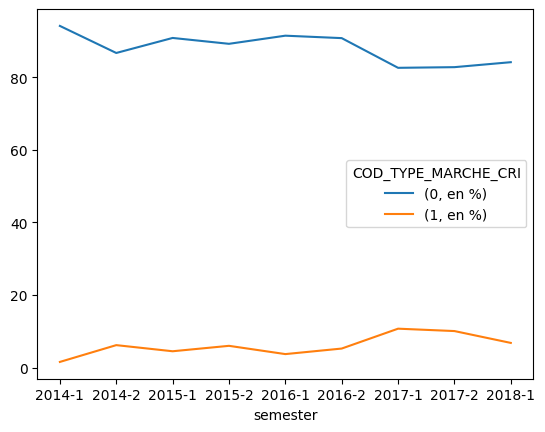

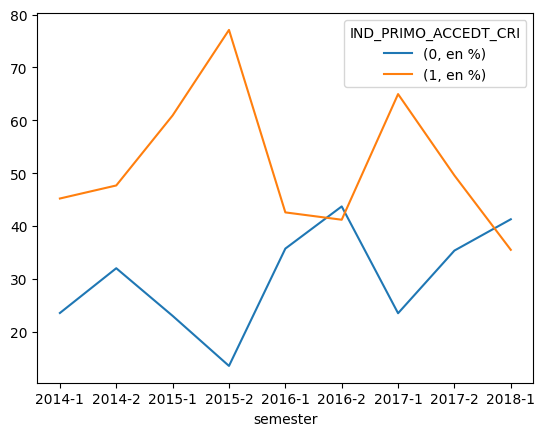

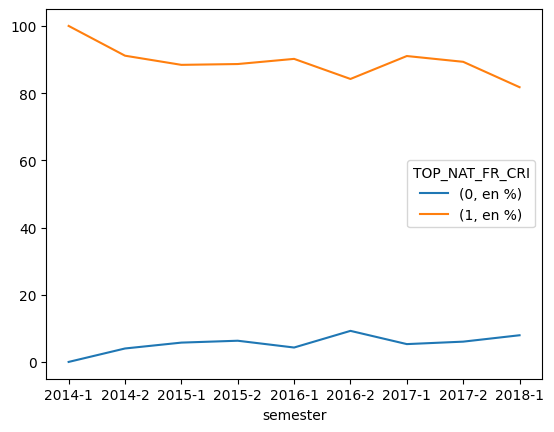

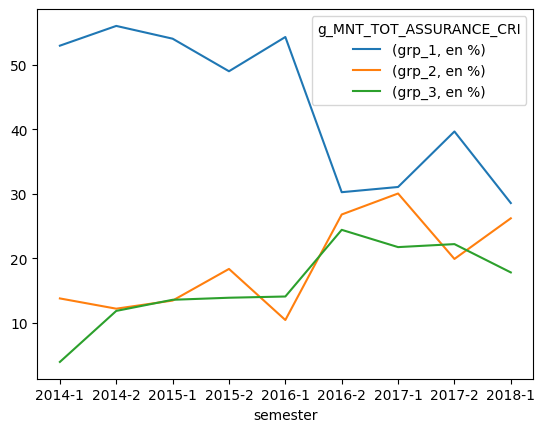

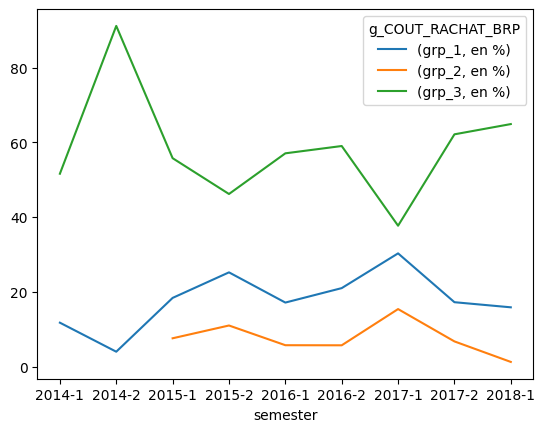

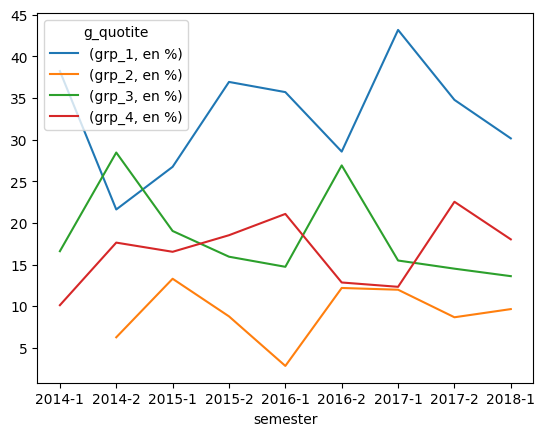

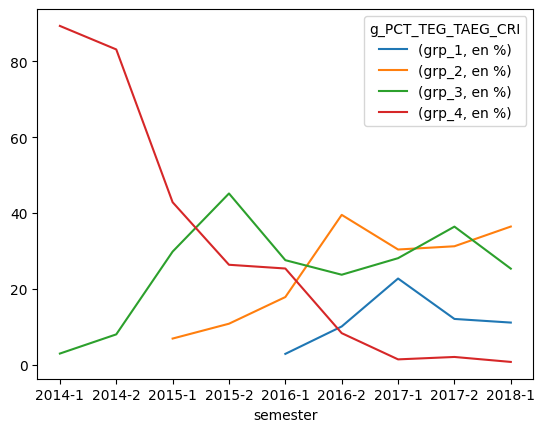

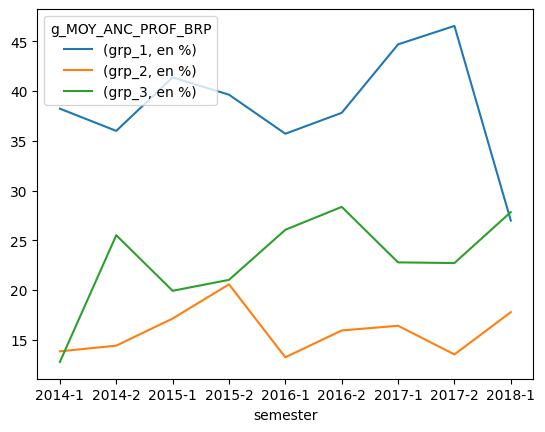

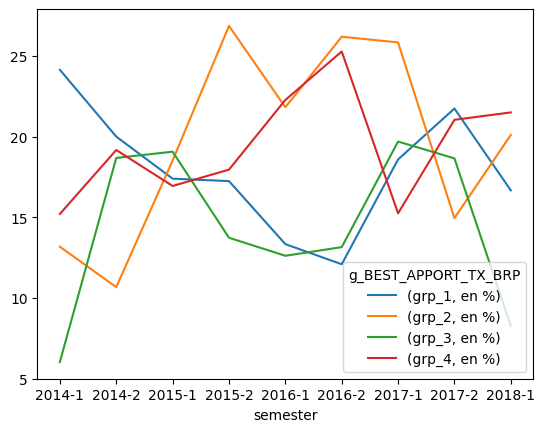

In [64]:
dataviz_stability(stability_data,time_interval='semester',stability_for_modelisation=True)

In [204]:
y_oot_base_clean=oot_base_clean["defaut_36mois"]
x_oot_base=oot_base_clean.drop(columns="defaut_36mois")
y_test_clean=X_test["defaut_36mois"]
x_test=X_test.drop(columns="defaut_36mois")

In [205]:
x_test=pipeline_processing(x_test, y_test_clean,quanti_selected_variables_basename,quali_selected_variables, selected_variables,stability_sample=False, training_option=False )
x_oot_base=pipeline_processing(x_oot_base, y_oot_base_clean,quanti_selected_variables_basename,quali_selected_variables,selected_variables,stability_sample=False, training_option=False )

IMPUTATION PAR 0
OK
IMPUTATION PAR MODE OU MEDIANE
OK
DONE
DONE
Check COD_ETA_BIEN_CRI is selected
DONE
Ces colonnes vont être retirées: ['MNT_TOT_ASSURANCE_CRI', 'COUT_RACHAT_BRP', 'SUM_PATR_IMMO_BRP', 'quotite', 'PCT_TEG_TAEG_CRI', 'MOY_ANC_PROF_BRP', 'nb_pret', 'MNT_COUT_TOT_CREDIT_CRI', 'BEST_APPORT_TX_BRP', 'COUT_PROJET_HF_AT_BRP', 'SUM_MTENCBIE_IMMO_BRP', 'MNT_PRET_CRI', 'AGE_INT_MAX_BRP']
DONE
IMPUTATION PAR 0
OK
IMPUTATION PAR MODE OU MEDIANE
OK
DONE
DONE
Check COD_ETA_BIEN_CRI is selected
DONE
Ces colonnes vont être retirées: ['MNT_TOT_ASSURANCE_CRI', 'COUT_RACHAT_BRP', 'SUM_PATR_IMMO_BRP', 'quotite', 'PCT_TEG_TAEG_CRI', 'MOY_ANC_PROF_BRP', 'nb_pret', 'MNT_COUT_TOT_CREDIT_CRI', 'BEST_APPORT_TX_BRP', 'COUT_PROJET_HF_AT_BRP', 'SUM_MTENCBIE_IMMO_BRP', 'MNT_PRET_CRI', 'AGE_INT_MAX_BRP']
DONE


Vérification pipeline: s'assurer que le nombre de modalités n'augmente pas si nouvelles modalités sur l'échantillon. Vu qu'on crée des dummies cela provoquera la création d'une nouvelle variable..

In [206]:

print(" Vérification de la taille du dataframe pour modélisation...")
print("Nombre de colonnes du dataframe x_train final en one-hot-encodant:",len(pd.get_dummies(X_train_selection[selected_variables],drop_first=True).columns))
print("Nombre de colonnes du dataframe test  en one-hot-encodant:",len(pd.get_dummies(x_test.drop(columns='defaut_36mois'),drop_first=True).columns))
print("Nombre de colonnes du dataframe OOT en one-hot-encodant:",len(pd.get_dummies(x_oot_base.drop(columns='defaut_36mois'),drop_first=True).columns))




 Vérification de la taille du dataframe pour modélisation...
Nombre de colonnes du dataframe x_train final en one-hot-encodant: 32
Nombre de colonnes du dataframe test  en one-hot-encodant: 32
Nombre de colonnes du dataframe OOT en one-hot-encodant: 32


In [207]:
x_oot_base.to_csv('x_oot.csv')
x_test.to_csv('x_test.csv')
X_train_selection.to_csv('x_train.csv')